## Setup Env: Run this before you start

In [17]:
#### pip & Data & license file

!pip3 install gurobipy
!pip install gdown

# Check for optional dependencies
try:
    import matplotlib_venn
    VENN_AVAILABLE = True
except ImportError:
    VENN_AVAILABLE = False
    print("matplotlib_venn not available. Install with 'pip install matplotlib-venn' for enhanced visualization.")

matplotlib_venn not available. Install with 'pip install matplotlib-venn' for enhanced visualization.


In [18]:
#### Download all dataset, (Andrew's personal academic) license

In [19]:
# Download all ambulance dataset. It will take some time. Depends on your network but about 3 min.
!gdown --folder https://drive.google.com/drive/folders/11Tx0kHH_8YVdTqHarfuBpTxGyN0JlLan

Retrieving folder contents
Retrieving folder 1rvfm7tc4c97093SKM44lNks5vIKpW80h 50
Processing file 1QGFUhgdUIh1xpLhtm7kkR36Au5HjhIWg 50-3004-6-7-35.bases
Processing file 1PBpKryGwPwfTW8j_qixRkoxTU5PRwExx 50-3004-6-7-35.gpickle
Processing file 1fVpicIGp_4nEMBE_kXrFguICfOrstVCN 50-3389-6-7-35.bases
Processing file 1RnrAmLncgLgHvMiLlVsKq_Dp1rYScNn4 50-3389-6-7-35.gpickle
Processing file 11qr63QVVIUy9N2XMfD0-iDCJ8RwgZrN_ 50-3557-6-7-35.bases
Processing file 1POhH7hzM7jSQpOs8_hxPKQ2MYErZxbPh 50-3557-6-7-35.gpickle
Processing file 1R78QzNOmMmtq5D4gdNxg20n-38fzpgAQ 50-4606-6-7-35.bases
Processing file 1RA_GY3iSVTVqYWW02YuGNY4Q3CDmhdDt 50-4606-6-7-35.gpickle
Processing file 1WHK4ui4IioQ36_3zQCfb1V66rLyG2D8m 50-9085-6-7-35.bases
Processing file 1qqCKSropECpo7913cb_kv-MEquo3zZCb 50-9085-6-7-35.gpickle
Retrieving folder 1HVzXqGApk742Os8BsvOxISBQ_HpFrZfW 100
Processing file 1ELejUUxZI0p1pFT8D15OMxBRshLdg0Ww 100-4090-6-7-35.bases
Processing file 1LV-_P86hJ3pQhsq24tLFrTDTuEXQ6ajc 100-4090-6-7-35.gpic

### When you have issue with the below code, access the upper google drive link and paste the "gurobi.lic" to "data" folder

In [20]:
# License
license_path = "data/gurobi.lic"

params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)  # Convert LICENSEID to int
            else:
                params[key] = value

# Check that it worked
print(params)

{'WLSACCESSID': '5cec81c9-a70e-4689-9487-28f5a1553f93', 'WLSSECRET': 'b583cde1-579c-4eb4-807e-d13bbe6446d7', 'LICENSEID': 2659300}


In [21]:
#### Dependencies

import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx
import time
import itertools
from collections import defaultdict
import math
import os
import pickle
import glob

# Gurobi

## Start Gurobi Session

In [22]:
env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu


## Gurobi Test Example

In [23]:
x = model.addVar(name="x")
y = model.addVar(name="y")

model.setObjective(x + y, gp.GRB.MAXIMIZE)
model.addConstr(x + 2*y <= 4, "c0")
model.addConstr(4*x + 2*y <= 12, "c1")

model.optimize()

for v in model.getVars():
    print(f'{v.varName} = {v.x}')

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xe530171d
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5000000e+30   3.250000e+30   1.500000e+00      0s
       2    3.3333333e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.333333333e+00
x = 2.6666666666666665
y = 0.6666666666666666


## VERY IMPORTANT : DISPOSE MODEL EVERYTIME

In [24]:
# After running Gurobi modle, YOU SHOULD ALWAYS PUT THIS TO END THE SESSION. THERE IS SESSION LIMITATION THAT CAN RUN SIMULTANEOUSLY

model.dispose()
env.dispose()

# Step0.A: Data Preparation

In [25]:
# Path to the dataset
DATA_DIR = "./data/50"
T_periods = 6  # you can set this manually or detect later if embedded

# Collect all .gpickle files in the folder
gpickle_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".gpickle")]
print(f"Found {len(gpickle_files)} instances in {DATA_DIR}")

Found 5 instances in ./data/50


In [26]:
# Loop through each file and load the graph
for g_file in gpickle_files:
    file_path = os.path.join(DATA_DIR, g_file)

    with open(file_path, 'rb') as f:
        G = pickle.load(f)

    if not isinstance(G, nx.Graph):
        print(f"{g_file}: ❌ Not a valid NetworkX graph.")
        continue

    n_areas = G.number_of_nodes()
    adjacency_matrix = nx.to_numpy_array(G)

    print(f"{g_file} → Nodes: {n_areas}, Adjacency matrix shape: {adjacency_matrix.shape}")

50-3557-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-4606-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-9085-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-3389-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-3004-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)


# Step0.B: Extract the neighbor relationships from each graph instance


🔍 Processing 50-3557-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(39.43104005216219), np.float64(-8.687110489642244)), (np.float64(59.38426359069778), np.float64(57.807086377787925)), (np.float64(-15.452713837273784), np.float64(73.50424573511431)), (np.float64(24.13035331104471), np.float64(115.0931163968403)), (np.float64(-11.662470782724931), np.float64(-35.087365644397124))]


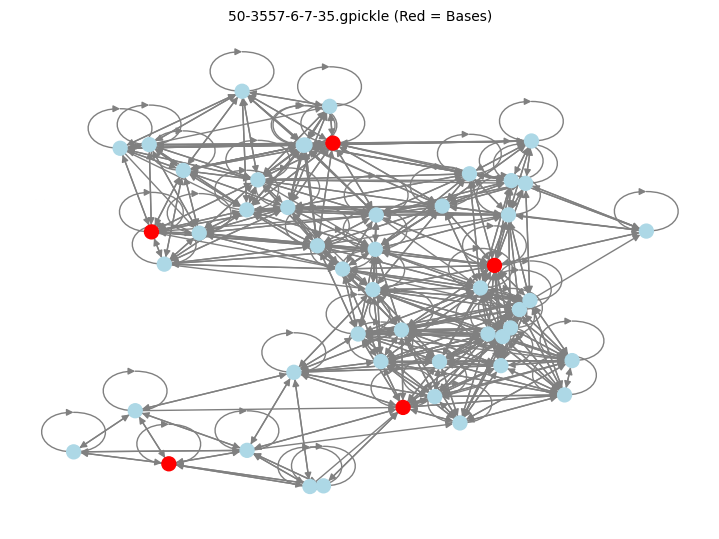


🔍 Processing 50-4606-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(82.83845044759052), np.float64(47.85496223887579)), (np.float64(10.988149826657938), np.float64(129.44835026452486)), (np.float64(85.12513261399491), np.float64(-33.64369858208566)), (np.float64(83.833842486748), np.float64(-6.453085862121561)), (np.float64(-14.220566362543144), np.float64(2.513939650472304))]


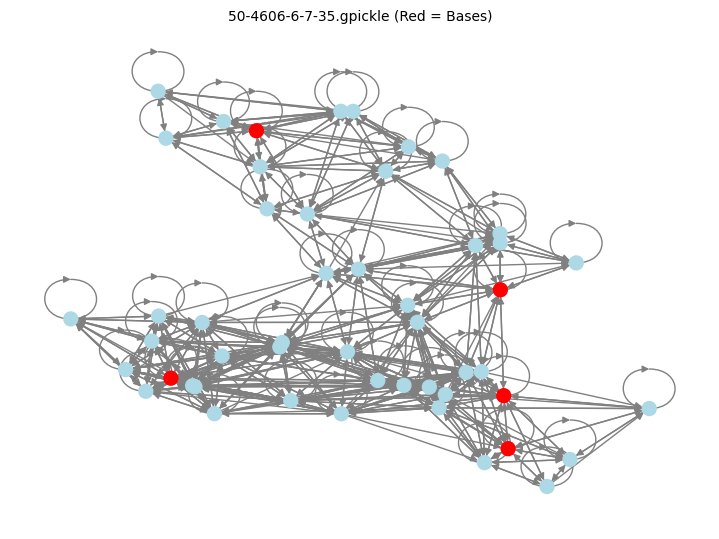


🔍 Processing 50-9085-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(61.554984900124545), np.float64(73.42342072749967)), (np.float64(61.90971107761959), np.float64(138.88151989167687)), (np.float64(86.08702733209572), np.float64(14.68491595588005)), (np.float64(103.21640975714642), np.float64(63.96713503209232)), (np.float64(33.03625809508789), np.float64(-6.935249336240362))]


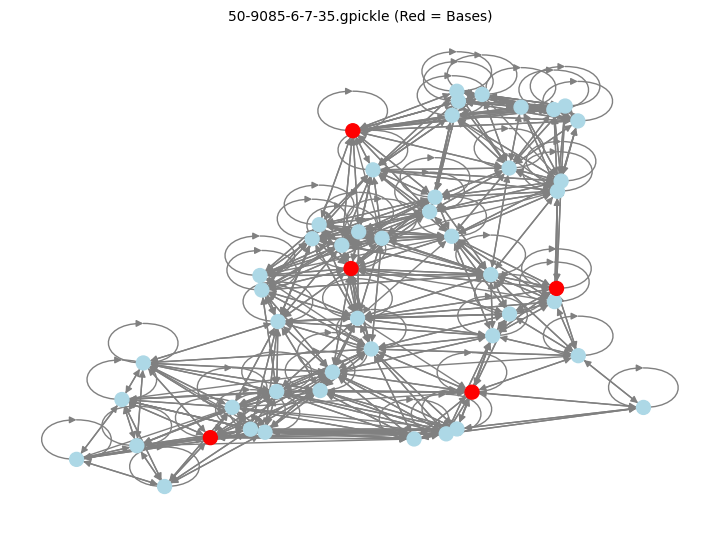


🔍 Processing 50-3389-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(116.4626296038246), np.float64(-33.9236888921012)), (np.float64(113.32965387275233), np.float64(19.299613644064806)), (np.float64(-43.19912667151699), np.float64(66.58289752405311)), (np.float64(28.28743505757513), np.float64(36.13181546187465)), (np.float64(76.80194058063708), np.float64(-19.16303956052547))]


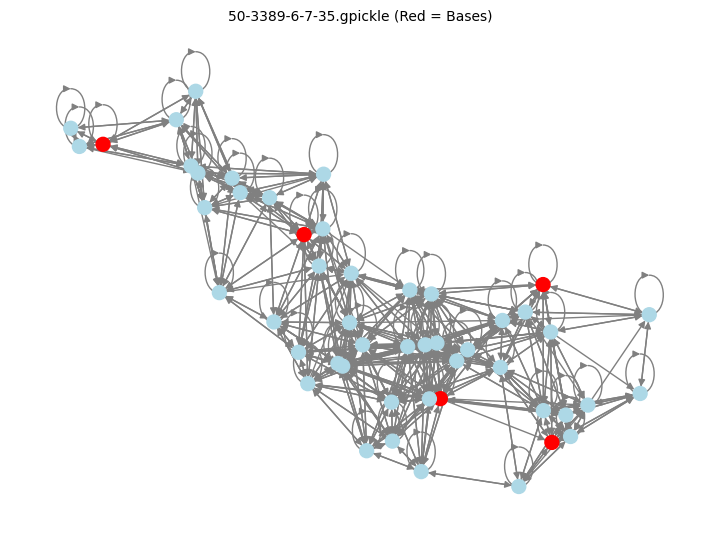


🔍 Processing 50-3004-6-7-35.gpickle
🚑 Base nodes matched: [(np.float64(31.787321838977057), np.float64(139.71582090950744)), (np.float64(-21.82513254086989), np.float64(14.334540113756065)), (np.float64(97.38961699220764), np.float64(14.638328691984295)), (np.float64(48.50591933747418), np.float64(-30.58059436441369)), (np.float64(-43.97216047743984), np.float64(107.46106685867151))]


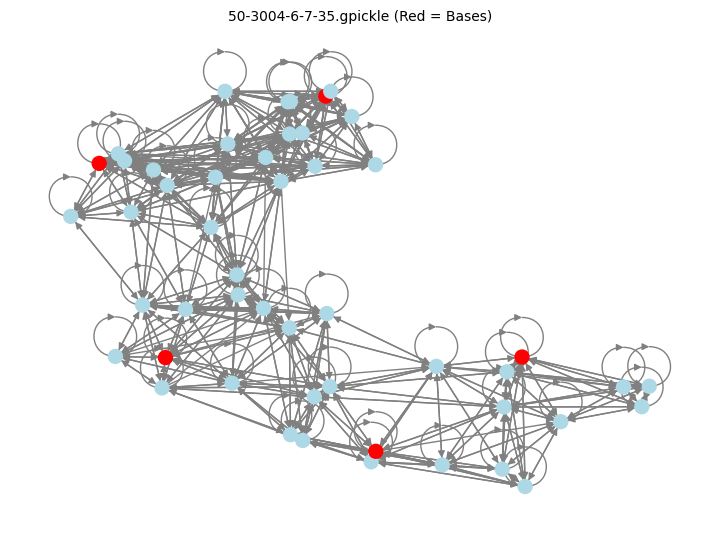

In [27]:
for g_file in gpickle_files:
    base_file = g_file.replace(".gpickle", ".bases")
    gpickle_path = os.path.join(DATA_DIR, g_file)
    base_path = os.path.join(DATA_DIR, base_file)

    print(f"\n🔍 Processing {g_file}")

    # Load the graph
    with open(gpickle_path, 'rb') as f:
        G = pickle.load(f)

    if not isinstance(G, nx.Graph):
        print(f"{g_file}: ❌ Not a valid graph.")
        continue

    # Extract all node labels (which are coordinate tuples)
    node_coords = list(G.nodes)

    # Load base coordinates from .bases file (as tuples)
    base_coords = []
    with open(base_path, 'r') as f:
        for line in f:
            if line.strip():
                coord = eval(line.strip())  # assumes format: (x, y)
                base_coords.append(coord)

    # Check which graph nodes match the base coordinates exactly
    base_nodes = [node for node in G.nodes if node in base_coords]
    print(f"🚑 Base nodes matched: {base_nodes}")

    # Color base nodes red, others light blue
    color_map = ['red' if node in base_nodes else 'lightblue' for node in G.nodes]

    # Build layout: use node coordinates as positions
    pos = {node: node for node in G.nodes}  # position = node coordinate

    # Draw the graph
    plt.figure(figsize=(7, 5))
    nx.draw(
        G, pos,
        with_labels=False,
        node_color=color_map,
        node_size=100,
        edge_color='gray',
    )
    plt.title(f"{g_file} (Red = Bases)", fontsize=10)
    plt.axis('off')
    plt.show()

# Step0.C: Generate All Valid Ambulance Paths (“Configurations”) = Column Generation

In [28]:
# --- SETTINGS ---
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
T = 6
OUTPUT_ROOT = f"configurations/50"

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.gpickle"), "rb") as f:
    G = pickle.load(f)
neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

# --- GENERATE FUNCTION ---
def generate_paths(current_path, steps_left, collected):
    if steps_left == 0:
        collected.append(current_path)
        return
    current_node = current_path[-1]
    for next_node in [current_node] + neighbors_dict.get(current_node, []):
        generate_paths(current_path + [next_node], steps_left - 1, collected)

# --- LOOP OVER BASES ---
for idx, base in enumerate(base_coords):
    configurations = []
    generate_paths([base], T - 1, configurations)

    # Create output dir
    out_dir = os.path.join(OUTPUT_ROOT, f"{FILENAME}-base{idx}_t0_{T-1}")
    os.makedirs(out_dir, exist_ok=True)

    # Save as .pkl
    with open(os.path.join(out_dir, "configs.pkl"), "wb") as f:
        pickle.dump(configurations, f)

    # Save as .csv
    flat_configs = []
    for cfg_id, cfg in enumerate(configurations):
        flat = [cfg_id]
        for t in range(T):
            flat.extend(cfg[t])
        flat_configs.append(flat)

    columns = ["config_id"] + [f"t{t}_{axis}" for t in range(T) for axis in ["x", "y"]]
    df = pd.DataFrame(flat_configs, columns=columns)
    df.to_csv(os.path.join(out_dir, "configs.csv"), index=False)

    print(f"✅ Base {idx}: saved {len(configurations)} configs to {out_dir}")

✅ Base 0: saved 821296 configs to configurations/50/50-3004-6-7-35-base0_t0_5
✅ Base 1: saved 392122 configs to configurations/50/50-3004-6-7-35-base1_t0_5
✅ Base 2: saved 1468840 configs to configurations/50/50-3004-6-7-35-base2_t0_5
✅ Base 3: saved 1595287 configs to configurations/50/50-3004-6-7-35-base3_t0_5
✅ Base 4: saved 214057 configs to configurations/50/50-3004-6-7-35-base4_t0_5


# STEP 1.A >>> Run experiments on a small dataset - Compare different batches of configurations and show how the fairness changes 

#### Master Problem ILP construction (Configuration-based / TESTING before batch processing : selecting one dataset, with only 100 configs)

In [29]:
# --- LICENSE ACTIVATION ---
env = gp.Env(params=params)
model = gp.Model(env=env)

# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
NUM_CONFIGS = 100  # for prototype testing

DATA_DIR = "./data/50"
CONFIG_CSV = "./configurations/50/50-3004-6-7-35-base0_t0_5/configs.csv"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD CONFIGS ---
df = pd.read_csv(CONFIG_CSV).head(NUM_CONFIGS)
configs = []
for _, row in df.iterrows():
    cfg = []
    for t in range(T):
        cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
    configs.append(cfg)

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
b = {}
for c_idx, config in enumerate(configs):
    for t, zone in enumerate(config):
        coverage = {zone} | adjacency.get(zone, set())
        for z in coverage:
            b[z, t, c_idx] = 1

# --- MODEL VARIABLES ---
λ = model.addVars(NUM_CONFIGS, vtype=GRB.BINARY, name="lambda")
y = model.addVars(zones, vtype=GRB.INTEGER, name="y")
z = model.addVar(vtype=GRB.INTEGER, name="z")

# --- CONSTRAINTS ---

# 1. Select exactly NUM_AMBULANCES configs
model.addConstr(gp.quicksum(λ[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count")

# 2. Define y_i = total coverage for each zone
for i in zones:
    model.addConstr(
        y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_{i}"
    )

# 3. Fairness constraint: z ≥ y_i - y_j
for i in zones:
    for j in zones:
        model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")

# --- OBJECTIVE ---
model.setObjective(z, GRB.MINIMIZE)

# --- SOLVE ---
model.optimize()

# --- OUTPUT ---
print("\n✅ Selected configuration indices:")
selected_configs = [c for c in range(NUM_CONFIGS) if λ[c].X > 0.5]
print(selected_configs)

print("\n✅ Zone coverage (y_i):")
for i in zones:
    print(f"Zone {i}: {int(y[i].X)}")

print(f"\n✅ Fairness gap (z*) = {int(z.X)}")

# --- CLEANUP ---

model.dispose()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 9327 nonzeros
Model fingerprint: 0xeed02ed3
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 4e+01]
Presolve removed 2284 rows and 64 columns
Presolve time: 0.01s
Presolved: 267 rows, 87 columns, 1642 nonzeros
Variable types: 0 continuous, 87 integer (34 binary)
Found heuristic solution: objective 194.0000000

Root relaxation: obje

# STEP 2 >>> Run experiments on the entire set of configurations - Compare the computation times and analyze the differences 

#### Master Problem ILP construction (Configuration-based / full comparison)

### For Base 0 - 821296 configs

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Found 1 base configurations (base0 only): ['50-3004-6-7-35-base0_t0_5']

🔄 Processing 35 for 50-3004-6-7-35
Config sizes for 35: [100, 362, 1313, 4760, 17252, 62527, 226613, 821295]
  🔁 Solving for NUM_CONFIGS = 100
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 9327 nonzeros
Model fingerprint: 0xeed02ed3
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient stat

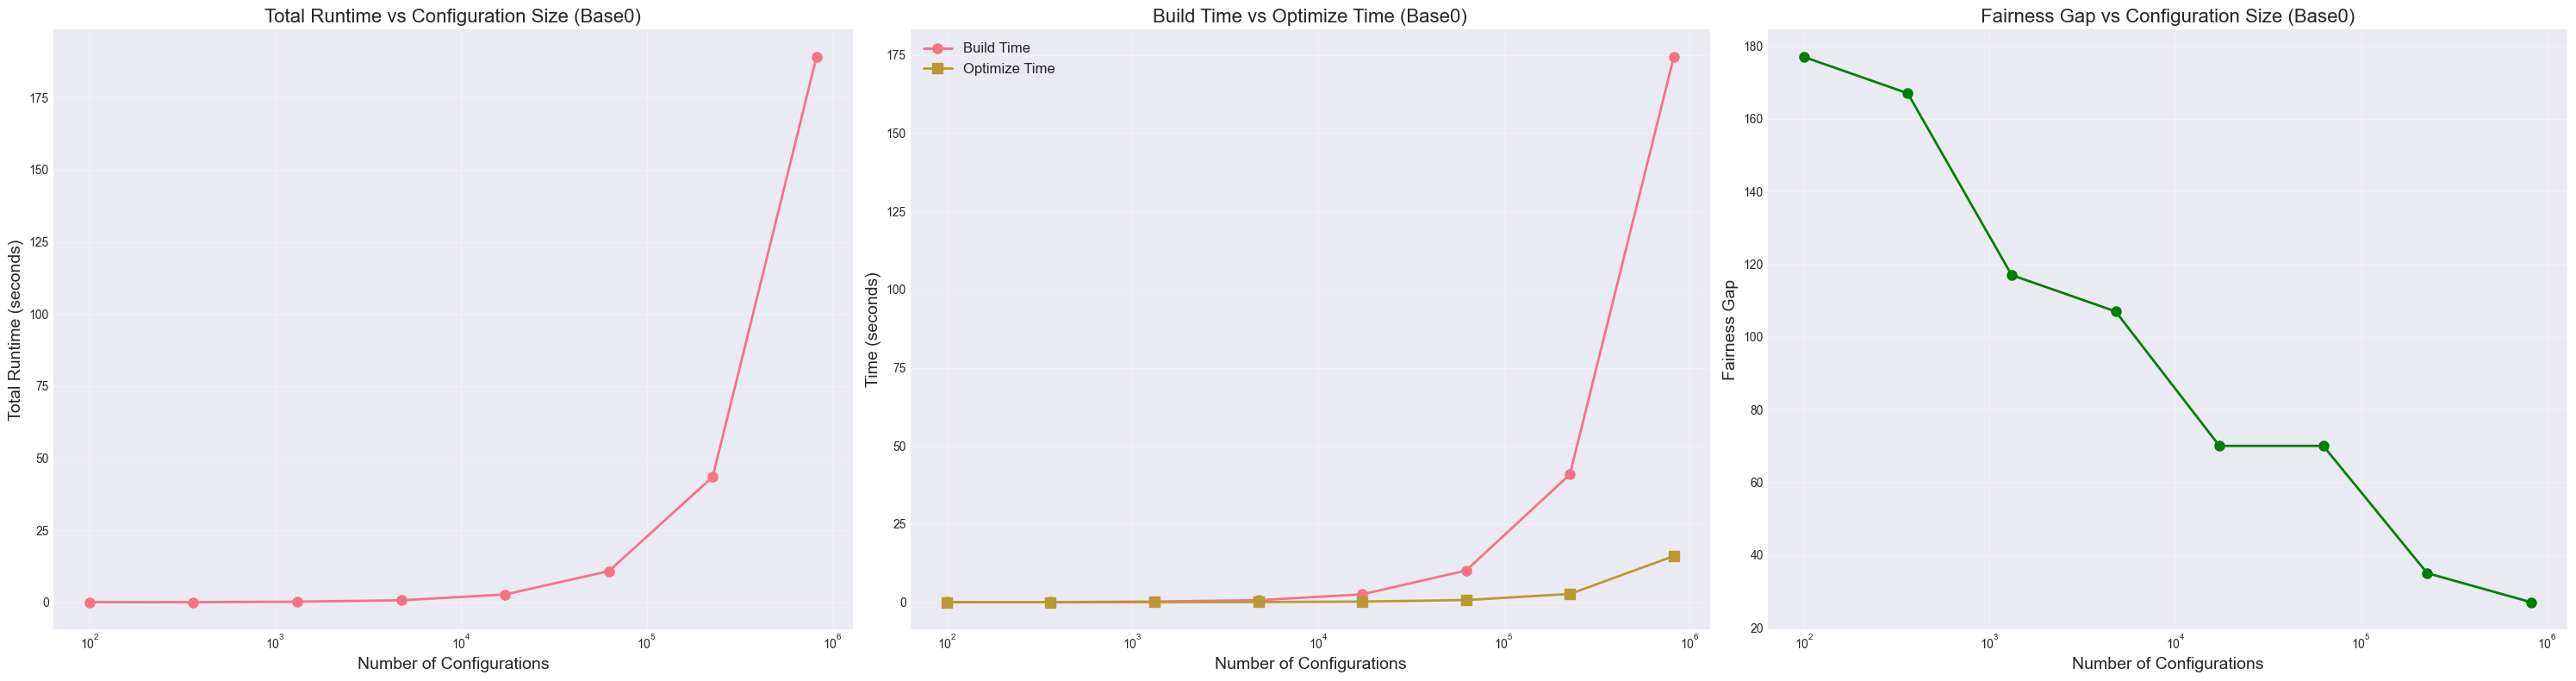


📊 Comprehensive Analysis Summary (Base0):
 Config Size  Total Time (s)  Build Time (s)  Optimize Time (s)  Fairness Gap  Variables  Constraints
         100        0.101593        0.080318           0.020248           177          0            0
         362        0.080267        0.058273           0.021178           167          0            0
        1313        0.259641        0.214738           0.043759           117          0            0
        4760        0.741866        0.666712           0.074352           107          0            0
       17252        2.748056        2.535220           0.212093            70          0            0
       62527       10.840275       10.136339           0.703211            70          0            0
      226613       43.535693       40.878870           2.656086            35          0            0
      821295      189.115645      174.354850          14.760046            27          0            0

📈 Key Performance Metrics (Base0):
Tot

In [44]:
# --- LICENSE ACTIVATION ---
env = gp.Env(params=params)

# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"

# Store results for all bases
all_results = {}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.gpickle"), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- GET ONLY BASE0 FILE ---
config_dir = "./configurations/50"
base_dirs = [d for d in os.listdir(config_dir)
             if d.startswith(f"{FILENAME}-base0") and "t0_5" in d]  # Only base0
base_dirs = sorted(base_dirs)

print(f"Found {len(base_dirs)} base configurations (base0 only): {base_dirs}")

# Better timing measurement approach
import time
import psutil
import matplotlib.pyplot as plt

# --- PROCESS ONLY BASE0 ---
for base_folder in base_dirs:
    base_id = base_folder.split("-")[-2]
    print(f"\n🔄 Processing {base_id} for {FILENAME}")

    # Check for configuration file
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if not os.path.exists(config_csv):
        print(f"⚠️ Config file not found for {base_folder}")
        continue

    # --- LOAD FULL CONFIG CSV ---
    df_full = pd.read_csv(config_csv)
    total_configs = len(df_full)

    # Create 8 interval sizes for this base (keep exactly 8)
    min_size = max(1, 100)
    max_size = total_configs
    config_sizes = np.logspace(np.log10(min_size), np.log10(max_size), 8, dtype=int).tolist()
    config_sizes = sorted(list(set(config_sizes)))  # Remove duplicates and sort

    print(f"Config sizes for {base_id}: {config_sizes}")

    fairness_results = []
    solve_times = []
    detailed_timings = []

    # --- LOOP OVER CONFIG SIZES ---
    for NUM_CONFIGS in config_sizes:
        NUM_CONFIGS = int(NUM_CONFIGS)
        print(f"  🔁 Solving for NUM_CONFIGS = {NUM_CONFIGS}")

        df = df_full.head(NUM_CONFIGS)
        configs = []
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
            configs.append(cfg)

        # --- COVERAGE MATRIX ---
        b = {}
        for c_idx, config in enumerate(configs):
            for t, zone in enumerate(config):
                coverage = {zone} | adjacency.get(zone, set())
                for z in coverage:
                    b[z, t, c_idx] = 1

        # --- TIMING IMPROVEMENTS ---
        timing_details = {}
        
        # 1. Measure total time including model creation
        full_start = time.time()
        
        # 2. Build model
        build_start = time.time()
        model = gp.Model(env=env)
        λ = model.addVars(NUM_CONFIGS, vtype=gp.GRB.BINARY, name="lambda")
        y = model.addVars(zones, vtype=gp.GRB.INTEGER, name="y")
        z = model.addVar(vtype=gp.GRB.INTEGER, name="z")

        model.addConstr(gp.quicksum(λ[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count")

        for i in zones:
            model.addConstr(
                y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(NUM_CONFIGS) for t in range(T)),
                f"coverage_{i}"
            )

        for i in zones:
            for j in zones:
                model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")

        model.setObjective(z, gp.GRB.MINIMIZE)
        timing_details['build_time'] = time.time() - build_start
        timing_details['num_vars'] = model.numVars
        timing_details['num_constraints'] = model.numConstrs
        
        # 3. Set up Gurobi settings for better timing
        model.setParam("OutputFlag", 1)  # Enable output to see what's happening
        model.setParam("TimeLimit", 600)  # Set time limit to 10 minutes
        model.setParam("MIPGap", 0.01)  # Set small gap to avoid excessive time
        
        # 4. Optimize with multiple timing measurements
        optimize_start = time.time()
        try:
            model.optimize()
            optimize_time = time.time() - optimize_start
            timing_details['optimize_time'] = optimize_time
            timing_details['status'] = model.status
            
            # Check if solution found
            if model.status == gp.GRB.OPTIMAL:
                fairness_gap = int(z.X)
                timing_details['solution_found'] = True
            elif model.status == gp.GRB.TIME_LIMIT:
                fairness_gap = int(z.X) if hasattr(z, 'X') else -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = "TIME LIMIT REACHED"
            else:
                fairness_gap = -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = f"Status: {model.status}"
                
        except Exception as e:
            optimize_time = time.time() - optimize_start
            fairness_gap = -1
            timing_details['error'] = str(e)
            timing_details['solution_found'] = False
        
        timing_details['total_time'] = time.time() - full_start
        
        print(f"    ✅ Fairness gap: {fairness_gap}")
        print(f"    ⏱️ Build time: {timing_details['build_time']:.2f}s")
        print(f"    ⏱️ Optimize time: {timing_details['optimize_time']:.2f}s") 
        print(f"    ⏱️ Total time: {timing_details['total_time']:.2f}s")
        print(f"    📊 Model stats: {model.numVars} vars, {model.numConstrs} constraints")
        print(f"    -----------------------------------------------------------------------")
        print(f"    -----------------------------------------------------------------------")
        print("\n")

        fairness_results.append(fairness_gap)
        solve_times.append(timing_details['total_time'])
        detailed_timings.append(timing_details)

        model.dispose()
    
    # Store results for this base
    all_results[base_id] = {
        'config_sizes': config_sizes,
        'fairness_gaps': fairness_results,
        'solve_times': solve_times,
        'detailed_timings': detailed_timings  # Store detailed timing info
    }

# --- COMPREHENSIVE VISUALIZATION FOR BASE0 ---

# Get the actual key for base0 data
base0_key = list(all_results.keys())[0]  # Get the first and only key
print(f"Using base0 key: {base0_key}")

# Extract data for base0
base0_data = all_results[base0_key]
config_sizes = base0_data['config_sizes']
total_times = base0_data['solve_times']
build_times = [t['build_time'] for t in base0_data['detailed_timings']]
optimize_times = [t['optimize_time'] for t in base0_data['detailed_timings']]
fairness_gaps = base0_data['fairness_gaps']
num_vars = [t['num_vars'] for t in base0_data['detailed_timings']]
num_constraints = [t['num_constraints'] for t in base0_data['detailed_timings']]

# Create figure with 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot 1: Total Time vs Configuration Size
ax1.plot(config_sizes, total_times, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Total Runtime (seconds)', fontsize=14)
ax1.set_title('Total Runtime vs Configuration Size (Base0)', fontsize=16)
ax1.grid(True, alpha=0.3)

# Plot 2: Build Time vs Optimize Time
ax2.plot(config_sizes, build_times, 'o-', linewidth=2, markersize=8, label='Build Time')
ax2.plot(config_sizes, optimize_times, 's-', linewidth=2, markersize=8, label='Optimize Time')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Time (seconds)', fontsize=14)
ax2.set_title('Build Time vs Optimize Time (Base0)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Fairness Gap vs Configuration Size
ax3.plot(config_sizes, fairness_gaps, 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Fairness Gap', fontsize=14)
ax3.set_title('Fairness Gap vs Configuration Size (Base0)', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('base0_analysis_simple.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table
summary_table = pd.DataFrame({
    'Config Size': config_sizes,
    'Total Time (s)': total_times,
    'Build Time (s)': build_times,
    'Optimize Time (s)': optimize_times,
    'Fairness Gap': fairness_gaps,
    'Variables': num_vars,
    'Constraints': num_constraints
})

print("\n📊 Comprehensive Analysis Summary (Base0):")
print(summary_table.to_string(index=False))

# Save summary to CSV
summary_table.to_csv('base0_analysis_simple.csv', index=False)

# Additional Statistical Analysis
print("\n📈 Key Performance Metrics (Base0):")
if len(total_times) > 0 and total_times[0] > 0:
    total_runtime_ratio = total_times[-1] / total_times[0]
    print(f"Total runtime ratio (largest/smallest): {total_runtime_ratio:.2f}x")
else:
    print("Total runtime ratio: N/A")

fairness_improvement = fairness_gaps[0] - fairness_gaps[-1]
print(f"Fairness improvement: {fairness_improvement}")

if len(build_times) > 0 and build_times[0] > 0:
    build_time_ratio = build_times[-1] / build_times[0]
    print(f"Build time scaling: {build_time_ratio:.2f}x")
else:
    print("Build time scaling: N/A")

if len(optimize_times) > 0 and optimize_times[0] > 0:
    optimize_time_ratio = optimize_times[-1] / optimize_times[0]
    print(f"Optimize time scaling: {optimize_time_ratio:.2f}x")
else:
    print("Optimize time scaling: N/A")

# Calculate average runtime per 100k configs safely
if len(total_times) > 0 and all(c > 0 for c in config_sizes):
    avg_runtime_per_100k = np.mean([t/(c/100000) for t, c in zip(total_times, config_sizes)])
    print(f"Average runtime per 100k configs: {avg_runtime_per_100k:.2f}s")
else:
    print("Average runtime per 100k configs: N/A")

# Clean up
env.dispose()

### For Base 1 - 392122 configs

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Found 1 base configurations (base1 only): ['50-3004-6-7-35-base1_t0_5']

🔄 Processing 35 for 50-3004-6-7-35
Config sizes for 35: [100, 326, 1063, 3467, 11307, 36874, 120247, 392122]
  🔁 Solving for NUM_CONFIGS = 100
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 9163 nonzeros
Model fingerprint: 0x2bb4143a
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient stat

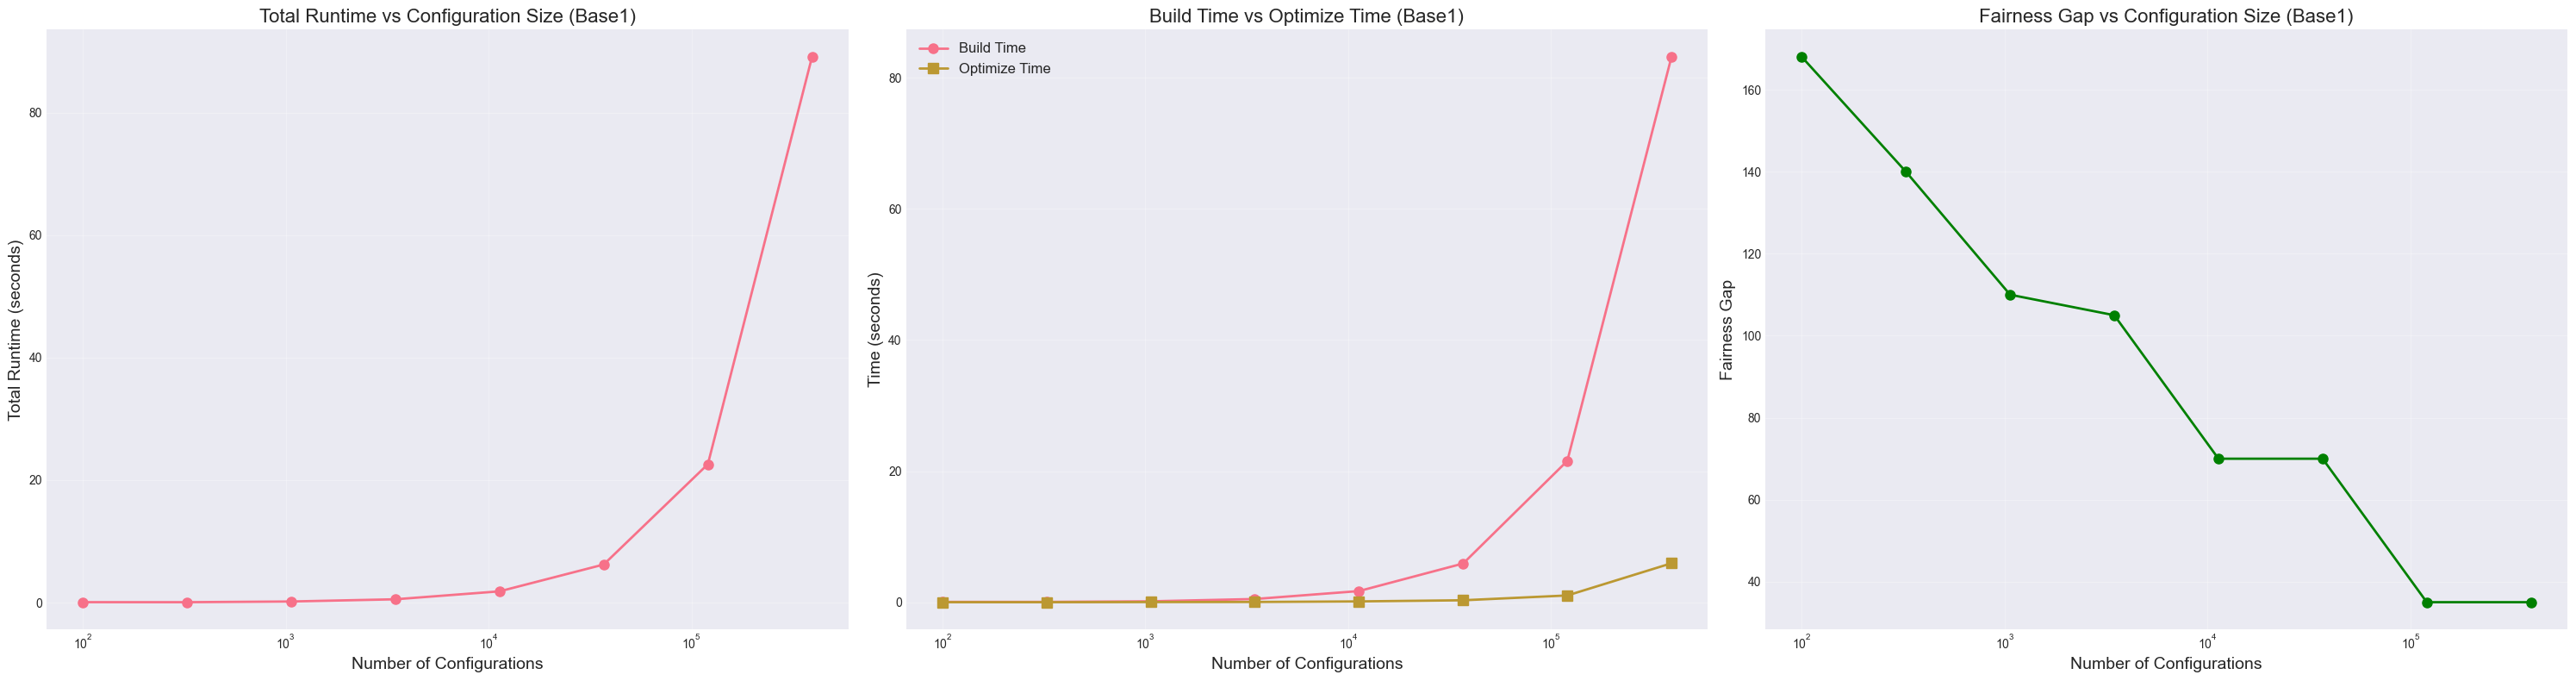


📊 Comprehensive Analysis Summary (Base1):
 Config Size  Total Time (s)  Build Time (s)  Optimize Time (s)  Fairness Gap  Variables  Constraints
         100        0.066525        0.054311           0.011498           168          0            0
         326        0.061497        0.052007           0.008822           140          0            0
        1063        0.174879        0.143947           0.030015           110          0            0
        3467        0.538141        0.494522           0.042785           105          0            0
       11307        1.834544        1.706377           0.127435            70          0            0
       36874        6.215188        5.911123           0.303188            70          0            0
      120247       22.598635       21.562240           1.035645            35          0            0
      392122       89.138343       83.192166           5.945361            35          0            0

📈 Key Performance Metrics (Base1):
Tot

In [45]:
# --- LICENSE ACTIVATION ---
env = gp.Env(params=params)

# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"

# Store results for all bases
all_results = {}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.gpickle"), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- GET ONLY BASE1 FILE ---
config_dir = "./configurations/50"
base_dirs = [d for d in os.listdir(config_dir)
             if d.startswith(f"{FILENAME}-base1") and "t0_5" in d]  # Only base1
base_dirs = sorted(base_dirs)

print(f"Found {len(base_dirs)} base configurations (base1 only): {base_dirs}")

# Better timing measurement approach
import time
import psutil
import matplotlib.pyplot as plt

# --- PROCESS ONLY BASE1 ---
for base_folder in base_dirs:
    base_id = base_folder.split("-")[-2]
    print(f"\n🔄 Processing {base_id} for {FILENAME}")

    # Check for configuration file
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if not os.path.exists(config_csv):
        print(f"⚠️ Config file not found for {base_folder}")
        continue

    # --- LOAD FULL CONFIG CSV ---
    df_full = pd.read_csv(config_csv)
    total_configs = len(df_full)

    # Create 8 interval sizes for this base (keep exactly 8)
    min_size = max(1, 100)
    max_size = total_configs
    config_sizes = np.logspace(np.log10(min_size), np.log10(max_size), 8, dtype=int).tolist()
    config_sizes = sorted(list(set(config_sizes)))  # Remove duplicates and sort

    print(f"Config sizes for {base_id}: {config_sizes}")

    fairness_results = []
    solve_times = []
    detailed_timings = []

    # --- LOOP OVER CONFIG SIZES ---
    for NUM_CONFIGS in config_sizes:
        NUM_CONFIGS = int(NUM_CONFIGS)
        print(f"  🔁 Solving for NUM_CONFIGS = {NUM_CONFIGS}")

        df = df_full.head(NUM_CONFIGS)
        configs = []
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
            configs.append(cfg)

        # --- COVERAGE MATRIX ---
        b = {}
        for c_idx, config in enumerate(configs):
            for t, zone in enumerate(config):
                coverage = {zone} | adjacency.get(zone, set())
                for z in coverage:
                    b[z, t, c_idx] = 1

        # --- TIMING IMPROVEMENTS ---
        timing_details = {}
        
        # 1. Measure total time including model creation
        full_start = time.time()
        
        # 2. Build model
        build_start = time.time()
        model = gp.Model(env=env)
        λ = model.addVars(NUM_CONFIGS, vtype=gp.GRB.BINARY, name="lambda")
        y = model.addVars(zones, vtype=gp.GRB.INTEGER, name="y")
        z = model.addVar(vtype=gp.GRB.INTEGER, name="z")

        model.addConstr(gp.quicksum(λ[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count")

        for i in zones:
            model.addConstr(
                y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(NUM_CONFIGS) for t in range(T)),
                f"coverage_{i}"
            )

        for i in zones:
            for j in zones:
                model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")

        model.setObjective(z, gp.GRB.MINIMIZE)
        timing_details['build_time'] = time.time() - build_start
        timing_details['num_vars'] = model.numVars
        timing_details['num_constraints'] = model.numConstrs
        
        # 3. Set up Gurobi settings for better timing
        model.setParam("OutputFlag", 1)  # Enable output to see what's happening
        model.setParam("TimeLimit", 600)  # Set time limit to 10 minutes
        model.setParam("MIPGap", 0.01)  # Set small gap to avoid excessive time
        
        # 4. Optimize with multiple timing measurements
        optimize_start = time.time()
        try:
            model.optimize()
            optimize_time = time.time() - optimize_start
            timing_details['optimize_time'] = optimize_time
            timing_details['status'] = model.status
            
            # Check if solution found
            if model.status == gp.GRB.OPTIMAL:
                fairness_gap = int(z.X)
                timing_details['solution_found'] = True
            elif model.status == gp.GRB.TIME_LIMIT:
                fairness_gap = int(z.X) if hasattr(z, 'X') else -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = "TIME LIMIT REACHED"
            else:
                fairness_gap = -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = f"Status: {model.status}"
                
        except Exception as e:
            optimize_time = time.time() - optimize_start
            fairness_gap = -1
            timing_details['error'] = str(e)
            timing_details['solution_found'] = False
        
        timing_details['total_time'] = time.time() - full_start
        
        print(f"    ✅ Fairness gap: {fairness_gap}")
        print(f"    ⏱️ Build time: {timing_details['build_time']:.2f}s")
        print(f"    ⏱️ Optimize time: {timing_details['optimize_time']:.2f}s") 
        print(f"    ⏱️ Total time: {timing_details['total_time']:.2f}s")
        print(f"    📊 Model stats: {model.numVars} vars, {model.numConstrs} constraints")
        print(f"    -----------------------------------------------------------------------")
        print(f"    -----------------------------------------------------------------------")
        print("\n")

        fairness_results.append(fairness_gap)
        solve_times.append(timing_details['total_time'])
        detailed_timings.append(timing_details)

        model.dispose()
    
    # Store results for this base
    all_results[base_id] = {
        'config_sizes': config_sizes,
        'fairness_gaps': fairness_results,
        'solve_times': solve_times,
        'detailed_timings': detailed_timings  # Store detailed timing info
    }

# --- COMPREHENSIVE VISUALIZATION FOR BASE1 ---

# Get the actual key for base1 data
base1_key = list(all_results.keys())[0]  # Get the first and only key
print(f"Using base1 key: {base1_key}")

# Extract data for base1
base1_data = all_results[base1_key]
config_sizes = base1_data['config_sizes']
total_times = base1_data['solve_times']
build_times = [t['build_time'] for t in base1_data['detailed_timings']]
optimize_times = [t['optimize_time'] for t in base1_data['detailed_timings']]
fairness_gaps = base1_data['fairness_gaps']
num_vars = [t['num_vars'] for t in base1_data['detailed_timings']]
num_constraints = [t['num_constraints'] for t in base1_data['detailed_timings']]

# Create figure with 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot 1: Total Time vs Configuration Size
ax1.plot(config_sizes, total_times, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Total Runtime (seconds)', fontsize=14)
ax1.set_title('Total Runtime vs Configuration Size (Base1)', fontsize=16)
ax1.grid(True, alpha=0.3)

# Plot 2: Build Time vs Optimize Time
ax2.plot(config_sizes, build_times, 'o-', linewidth=2, markersize=8, label='Build Time')
ax2.plot(config_sizes, optimize_times, 's-', linewidth=2, markersize=8, label='Optimize Time')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Time (seconds)', fontsize=14)
ax2.set_title('Build Time vs Optimize Time (Base1)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Fairness Gap vs Configuration Size
ax3.plot(config_sizes, fairness_gaps, 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Fairness Gap', fontsize=14)
ax3.set_title('Fairness Gap vs Configuration Size (Base1)', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('base1_analysis_simple.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table
summary_table = pd.DataFrame({
    'Config Size': config_sizes,
    'Total Time (s)': total_times,
    'Build Time (s)': build_times,
    'Optimize Time (s)': optimize_times,
    'Fairness Gap': fairness_gaps,
    'Variables': num_vars,
    'Constraints': num_constraints
})

print("\n📊 Comprehensive Analysis Summary (Base1):")
print(summary_table.to_string(index=False))

# Save summary to CSV
summary_table.to_csv('base1_analysis_simple.csv', index=False)

# Additional Statistical Analysis
print("\n📈 Key Performance Metrics (Base1):")
if len(total_times) > 0 and total_times[0] > 0:
    total_runtime_ratio = total_times[-1] / total_times[0]
    print(f"Total runtime ratio (largest/smallest): {total_runtime_ratio:.2f}x")
else:
    print("Total runtime ratio: N/A")

fairness_improvement = fairness_gaps[0] - fairness_gaps[-1]
print(f"Fairness improvement: {fairness_improvement}")

if len(build_times) > 0 and build_times[0] > 0:
    build_time_ratio = build_times[-1] / build_times[0]
    print(f"Build time scaling: {build_time_ratio:.2f}x")
else:
    print("Build time scaling: N/A")

if len(optimize_times) > 0 and optimize_times[0] > 0:
    optimize_time_ratio = optimize_times[-1] / optimize_times[0]
    print(f"Optimize time scaling: {optimize_time_ratio:.2f}x")
else:
    print("Optimize time scaling: N/A")

# Calculate average runtime per 100k configs safely
if len(total_times) > 0 and all(c > 0 for c in config_sizes):
    avg_runtime_per_100k = np.mean([t/(c/100000) for t, c in zip(total_times, config_sizes)])
    print(f"Average runtime per 100k configs: {avg_runtime_per_100k:.2f}s")
else:
    print("Average runtime per 100k configs: N/A")

# Clean up
env.dispose()

### For Base 2 - 1468840 configs

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Found 1 base configurations (base2 only): ['50-3004-6-7-35-base2_t0_5']

🔄 Processing 35 for 50-3004-6-7-35
Config sizes for 35: [100, 393, 1550, 6107, 24050, 94713, 372985, 1468839]
  🔁 Solving for NUM_CONFIGS = 100
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 8959 nonzeros
Model fingerprint: 0x6305d7d2
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient sta

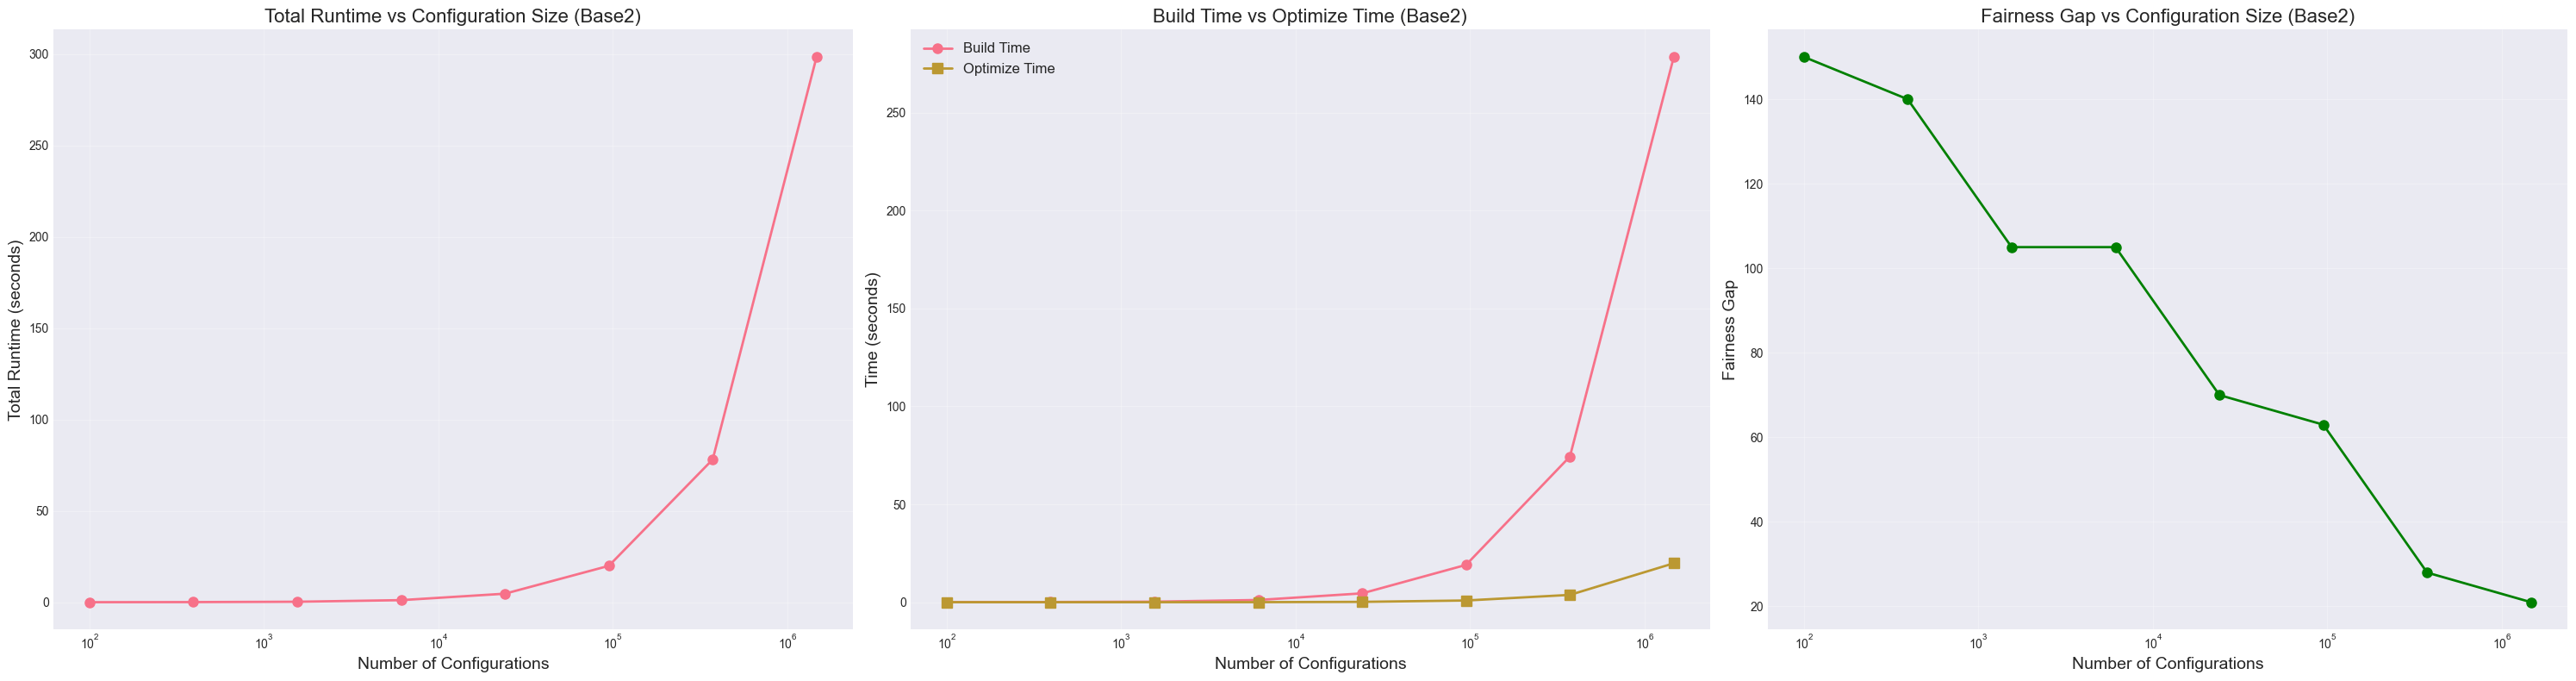


📊 Comprehensive Analysis Summary (Base2):
 Config Size  Total Time (s)  Build Time (s)  Optimize Time (s)  Fairness Gap  Variables  Constraints
         100        0.047517        0.038885           0.007723           150          0            0
         393        0.103125        0.090415           0.011993           140          0            0
        1550        0.292459        0.275069           0.016637           105          0            0
        6107        1.168853        1.135383           0.032714           105          0            0
       24050        4.698375        4.523552           0.174075            70          0            0
       94713       19.943196       19.064975           0.877342            63          0            0
      372985       78.155387       74.415065           3.739532            28          0            0
     1468839      298.423100      278.532721          19.889612            21          0            0

📈 Key Performance Metrics (Base2):
Tot

In [46]:
# --- LICENSE ACTIVATION ---
env = gp.Env(params=params)

# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"

# Store results for all bases
all_results = {}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.gpickle"), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- GET ONLY BASE2 FILE ---
config_dir = "./configurations/50"
base_dirs = [d for d in os.listdir(config_dir)
             if d.startswith(f"{FILENAME}-base2") and "t0_5" in d]  # Only base2
base_dirs = sorted(base_dirs)

print(f"Found {len(base_dirs)} base configurations (base2 only): {base_dirs}")

# Better timing measurement approach
import time
import psutil
import matplotlib.pyplot as plt

# --- PROCESS ONLY BASE2 ---
for base_folder in base_dirs:
    base_id = base_folder.split("-")[-2]
    print(f"\n🔄 Processing {base_id} for {FILENAME}")

    # Check for configuration file
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if not os.path.exists(config_csv):
        print(f"⚠️ Config file not found for {base_folder}")
        continue

    # --- LOAD FULL CONFIG CSV ---
    df_full = pd.read_csv(config_csv)
    total_configs = len(df_full)

    # Create 8 interval sizes for this base (keep exactly 8)
    min_size = max(1, 100)
    max_size = total_configs
    config_sizes = np.logspace(np.log10(min_size), np.log10(max_size), 8, dtype=int).tolist()
    config_sizes = sorted(list(set(config_sizes)))  # Remove duplicates and sort

    print(f"Config sizes for {base_id}: {config_sizes}")

    fairness_results = []
    solve_times = []
    detailed_timings = []

    # --- LOOP OVER CONFIG SIZES ---
    for NUM_CONFIGS in config_sizes:
        NUM_CONFIGS = int(NUM_CONFIGS)
        print(f"  🔁 Solving for NUM_CONFIGS = {NUM_CONFIGS}")

        df = df_full.head(NUM_CONFIGS)
        configs = []
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
            configs.append(cfg)

        # --- COVERAGE MATRIX ---
        b = {}
        for c_idx, config in enumerate(configs):
            for t, zone in enumerate(config):
                coverage = {zone} | adjacency.get(zone, set())
                for z in coverage:
                    b[z, t, c_idx] = 1

        # --- TIMING IMPROVEMENTS ---
        timing_details = {}
        
        # 1. Measure total time including model creation
        full_start = time.time()
        
        # 2. Build model
        build_start = time.time()
        model = gp.Model(env=env)
        λ = model.addVars(NUM_CONFIGS, vtype=gp.GRB.BINARY, name="lambda")
        y = model.addVars(zones, vtype=gp.GRB.INTEGER, name="y")
        z = model.addVar(vtype=gp.GRB.INTEGER, name="z")

        model.addConstr(gp.quicksum(λ[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count")

        for i in zones:
            model.addConstr(
                y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(NUM_CONFIGS) for t in range(T)),
                f"coverage_{i}"
            )

        for i in zones:
            for j in zones:
                model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")

        model.setObjective(z, gp.GRB.MINIMIZE)
        timing_details['build_time'] = time.time() - build_start
        timing_details['num_vars'] = model.numVars
        timing_details['num_constraints'] = model.numConstrs
        
        # 3. Set up Gurobi settings for better timing
        model.setParam("OutputFlag", 1)  # Enable output to see what's happening
        model.setParam("TimeLimit", 600)  # Set time limit to 10 minutes
        model.setParam("MIPGap", 0.01)  # Set small gap to avoid excessive time
        
        # 4. Optimize with multiple timing measurements
        optimize_start = time.time()
        try:
            model.optimize()
            optimize_time = time.time() - optimize_start
            timing_details['optimize_time'] = optimize_time
            timing_details['status'] = model.status
            
            # Check if solution found
            if model.status == gp.GRB.OPTIMAL:
                fairness_gap = int(z.X)
                timing_details['solution_found'] = True
            elif model.status == gp.GRB.TIME_LIMIT:
                fairness_gap = int(z.X) if hasattr(z, 'X') else -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = "TIME LIMIT REACHED"
            else:
                fairness_gap = -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = f"Status: {model.status}"
                
        except Exception as e:
            optimize_time = time.time() - optimize_start
            fairness_gap = -1
            timing_details['error'] = str(e)
            timing_details['solution_found'] = False
        
        timing_details['total_time'] = time.time() - full_start
        
        print(f"    ✅ Fairness gap: {fairness_gap}")
        print(f"    ⏱️ Build time: {timing_details['build_time']:.2f}s")
        print(f"    ⏱️ Optimize time: {timing_details['optimize_time']:.2f}s") 
        print(f"    ⏱️ Total time: {timing_details['total_time']:.2f}s")
        print(f"    📊 Model stats: {model.numVars} vars, {model.numConstrs} constraints")
        print(f"    -----------------------------------------------------------------------")
        print(f"    -----------------------------------------------------------------------")
        print("\n")

        fairness_results.append(fairness_gap)
        solve_times.append(timing_details['total_time'])
        detailed_timings.append(timing_details)

        model.dispose()
    
    # Store results for this base
    all_results[base_id] = {
        'config_sizes': config_sizes,
        'fairness_gaps': fairness_results,
        'solve_times': solve_times,
        'detailed_timings': detailed_timings  # Store detailed timing info
    }

# --- COMPREHENSIVE VISUALIZATION FOR BASE2 ---

# Get the actual key for base2 data
base2_key = list(all_results.keys())[0]  # Get the first and only key
print(f"Using base2 key: {base2_key}")

# Extract data for base2
base2_data = all_results[base2_key]
config_sizes = base2_data['config_sizes']
total_times = base2_data['solve_times']
build_times = [t['build_time'] for t in base2_data['detailed_timings']]
optimize_times = [t['optimize_time'] for t in base2_data['detailed_timings']]
fairness_gaps = base2_data['fairness_gaps']
num_vars = [t['num_vars'] for t in base2_data['detailed_timings']]
num_constraints = [t['num_constraints'] for t in base2_data['detailed_timings']]

# Create figure with 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot 1: Total Time vs Configuration Size
ax1.plot(config_sizes, total_times, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Total Runtime (seconds)', fontsize=14)
ax1.set_title('Total Runtime vs Configuration Size (Base2)', fontsize=16)
ax1.grid(True, alpha=0.3)

# Plot 2: Build Time vs Optimize Time
ax2.plot(config_sizes, build_times, 'o-', linewidth=2, markersize=8, label='Build Time')
ax2.plot(config_sizes, optimize_times, 's-', linewidth=2, markersize=8, label='Optimize Time')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Time (seconds)', fontsize=14)
ax2.set_title('Build Time vs Optimize Time (Base2)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Fairness Gap vs Configuration Size
ax3.plot(config_sizes, fairness_gaps, 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Fairness Gap', fontsize=14)
ax3.set_title('Fairness Gap vs Configuration Size (Base2)', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('base2_analysis_simple.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table
summary_table = pd.DataFrame({
    'Config Size': config_sizes,
    'Total Time (s)': total_times,
    'Build Time (s)': build_times,
    'Optimize Time (s)': optimize_times,
    'Fairness Gap': fairness_gaps,
    'Variables': num_vars,
    'Constraints': num_constraints
})

print("\n📊 Comprehensive Analysis Summary (Base2):")
print(summary_table.to_string(index=False))

# Save summary to CSV
summary_table.to_csv('base2_analysis_simple.csv', index=False)

# Additional Statistical Analysis
print("\n📈 Key Performance Metrics (Base2):")
if len(total_times) > 0 and total_times[0] > 0:
    total_runtime_ratio = total_times[-1] / total_times[0]
    print(f"Total runtime ratio (largest/smallest): {total_runtime_ratio:.2f}x")
else:
    print("Total runtime ratio: N/A")

fairness_improvement = fairness_gaps[0] - fairness_gaps[-1]
print(f"Fairness improvement: {fairness_improvement}")

if len(build_times) > 0 and build_times[0] > 0:
    build_time_ratio = build_times[-1] / build_times[0]
    print(f"Build time scaling: {build_time_ratio:.2f}x")
else:
    print("Build time scaling: N/A")

if len(optimize_times) > 0 and optimize_times[0] > 0:
    optimize_time_ratio = optimize_times[-1] / optimize_times[0]
    print(f"Optimize time scaling: {optimize_time_ratio:.2f}x")
else:
    print("Optimize time scaling: N/A")

# Calculate average runtime per 100k configs safely
if len(total_times) > 0 and all(c > 0 for c in config_sizes):
    avg_runtime_per_100k = np.mean([t/(c/100000) for t, c in zip(total_times, config_sizes)])
    print(f"Average runtime per 100k configs: {avg_runtime_per_100k:.2f}s")
else:
    print("Average runtime per 100k configs: N/A")

# Clean up
env.dispose()

### For Base 3 - 1595287 configs

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Found 1 base configurations (base3 only): ['50-3004-6-7-35-base3_t0_5']

🔄 Processing 35 for 50-3004-6-7-35
Config sizes for 35: [100, 398, 1587, 6327, 25212, 100467, 400343, 1595287]
  🔁 Solving for NUM_CONFIGS = 100
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 9296 nonzeros
Model fingerprint: 0xbda04337
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient st

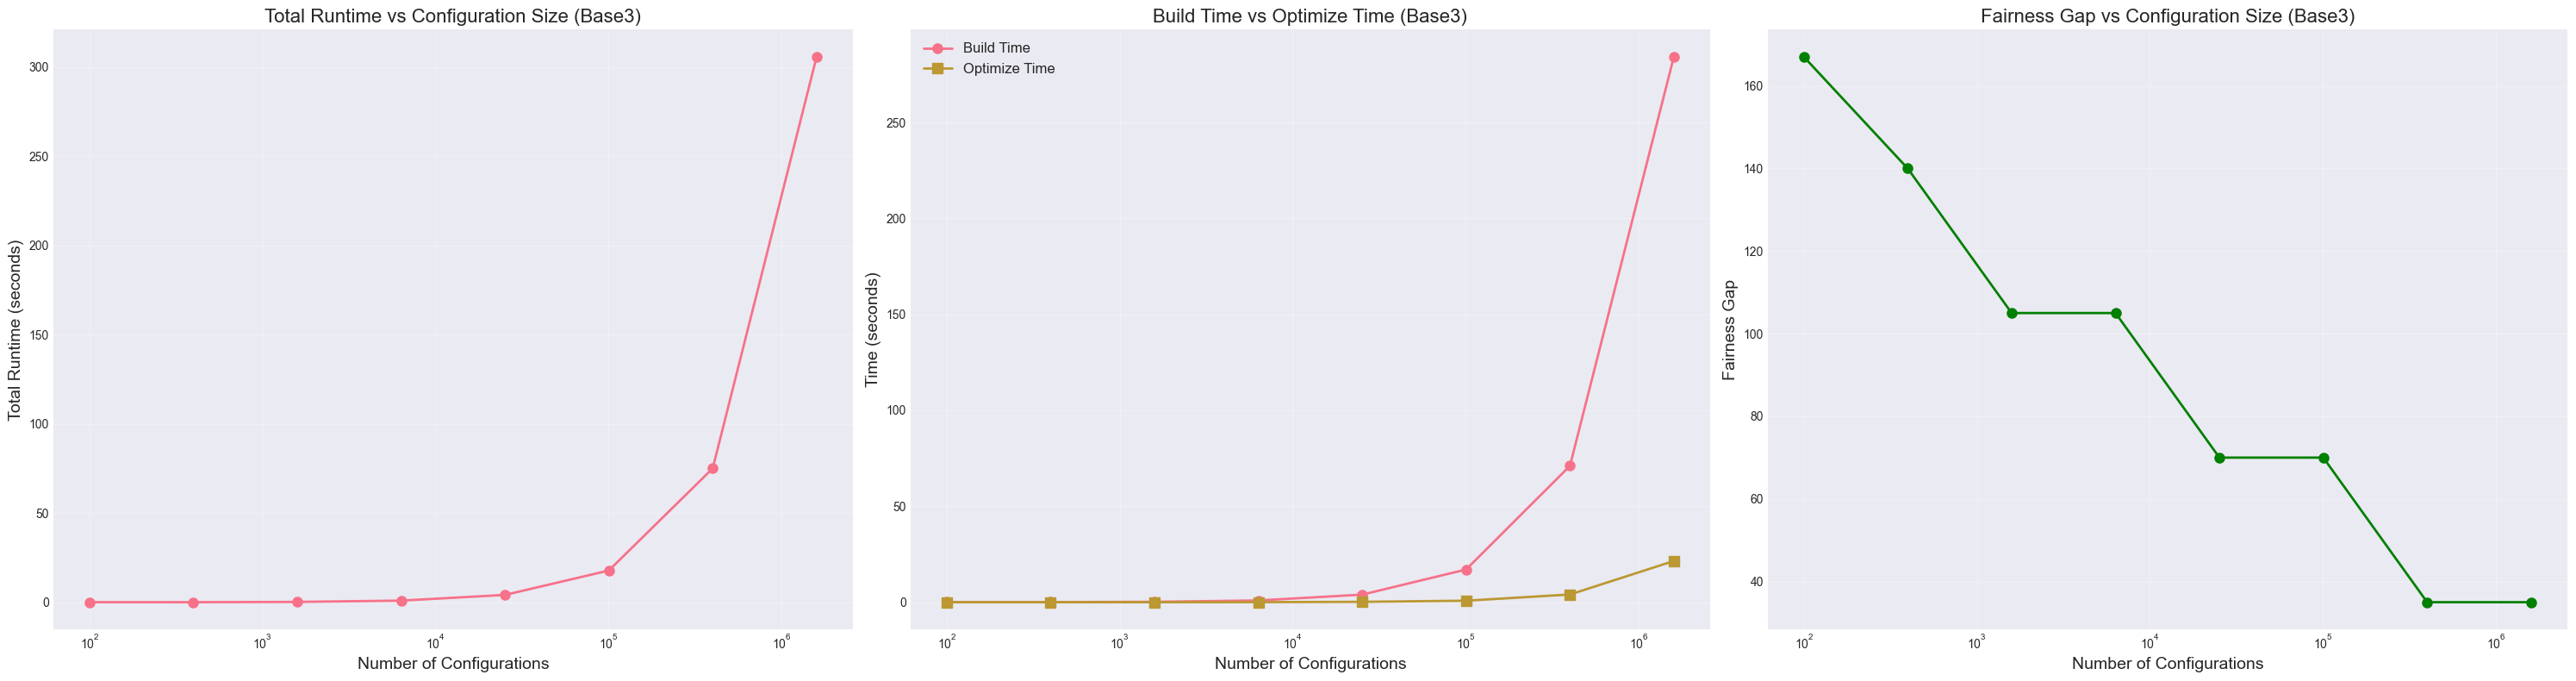


📊 Comprehensive Analysis Summary (Base3):
 Config Size  Total Time (s)  Build Time (s)  Optimize Time (s)  Fairness Gap  Variables  Constraints
         100        0.080898        0.069609           0.010562           167          0            0
         398        0.072117        0.061303           0.010099           140          0            0
        1587        0.229580        0.210331           0.018583           105          0            0
        6327        0.952620        0.911896           0.039994           105          0            0
       25212        4.150124        3.950308           0.199022            70          0            0
      100467       17.823592       17.030787           0.792105            70          0            0
      400343       75.048608       71.029084           4.018577            35          0            0
     1595287      305.601157      284.136338          21.464063            35          0            0

📈 Key Performance Metrics (Base3):
Tot

In [47]:
# --- LICENSE ACTIVATION ---
env = gp.Env(params=params)

# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"

# Store results for all bases
all_results = {}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.gpickle"), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- GET ONLY BASE3 FILE ---
config_dir = "./configurations/50"
base_dirs = [d for d in os.listdir(config_dir)
             if d.startswith(f"{FILENAME}-base3") and "t0_5" in d]  # Only base3
base_dirs = sorted(base_dirs)

print(f"Found {len(base_dirs)} base configurations (base3 only): {base_dirs}")

# Better timing measurement approach
import time
import psutil
import matplotlib.pyplot as plt

# --- PROCESS ONLY BASE3 ---
for base_folder in base_dirs:
    base_id = base_folder.split("-")[-2]
    print(f"\n🔄 Processing {base_id} for {FILENAME}")

    # Check for configuration file
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if not os.path.exists(config_csv):
        print(f"⚠️ Config file not found for {base_folder}")
        continue

    # --- LOAD FULL CONFIG CSV ---
    df_full = pd.read_csv(config_csv)
    total_configs = len(df_full)

    # Create 8 interval sizes for this base (keep exactly 8)
    min_size = max(1, 100)
    max_size = total_configs
    config_sizes = np.logspace(np.log10(min_size), np.log10(max_size), 8, dtype=int).tolist()
    config_sizes = sorted(list(set(config_sizes)))  # Remove duplicates and sort

    print(f"Config sizes for {base_id}: {config_sizes}")

    fairness_results = []
    solve_times = []
    detailed_timings = []

    # --- LOOP OVER CONFIG SIZES ---
    for NUM_CONFIGS in config_sizes:
        NUM_CONFIGS = int(NUM_CONFIGS)
        print(f"  🔁 Solving for NUM_CONFIGS = {NUM_CONFIGS}")

        df = df_full.head(NUM_CONFIGS)
        configs = []
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
            configs.append(cfg)

        # --- COVERAGE MATRIX ---
        b = {}
        for c_idx, config in enumerate(configs):
            for t, zone in enumerate(config):
                coverage = {zone} | adjacency.get(zone, set())
                for z in coverage:
                    b[z, t, c_idx] = 1

        # --- TIMING IMPROVEMENTS ---
        timing_details = {}
        
        # 1. Measure total time including model creation
        full_start = time.time()
        
        # 2. Build model
        build_start = time.time()
        model = gp.Model(env=env)
        λ = model.addVars(NUM_CONFIGS, vtype=gp.GRB.BINARY, name="lambda")
        y = model.addVars(zones, vtype=gp.GRB.INTEGER, name="y")
        z = model.addVar(vtype=gp.GRB.INTEGER, name="z")

        model.addConstr(gp.quicksum(λ[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count")

        for i in zones:
            model.addConstr(
                y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(NUM_CONFIGS) for t in range(T)),
                f"coverage_{i}"
            )

        for i in zones:
            for j in zones:
                model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")

        model.setObjective(z, gp.GRB.MINIMIZE)
        timing_details['build_time'] = time.time() - build_start
        timing_details['num_vars'] = model.numVars
        timing_details['num_constraints'] = model.numConstrs
        
        # 3. Set up Gurobi settings for better timing
        model.setParam("OutputFlag", 1)  # Enable output to see what's happening
        model.setParam("TimeLimit", 600)  # Set time limit to 10 minutes
        model.setParam("MIPGap", 0.01)  # Set small gap to avoid excessive time
        
        # 4. Optimize with multiple timing measurements
        optimize_start = time.time()
        try:
            model.optimize()
            optimize_time = time.time() - optimize_start
            timing_details['optimize_time'] = optimize_time
            timing_details['status'] = model.status
            
            # Check if solution found
            if model.status == gp.GRB.OPTIMAL:
                fairness_gap = int(z.X)
                timing_details['solution_found'] = True
            elif model.status == gp.GRB.TIME_LIMIT:
                fairness_gap = int(z.X) if hasattr(z, 'X') else -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = "TIME LIMIT REACHED"
            else:
                fairness_gap = -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = f"Status: {model.status}"
                
        except Exception as e:
            optimize_time = time.time() - optimize_start
            fairness_gap = -1
            timing_details['error'] = str(e)
            timing_details['solution_found'] = False
        
        timing_details['total_time'] = time.time() - full_start
        
        print(f"    ✅ Fairness gap: {fairness_gap}")
        print(f"    ⏱️ Build time: {timing_details['build_time']:.2f}s")
        print(f"    ⏱️ Optimize time: {timing_details['optimize_time']:.2f}s") 
        print(f"    ⏱️ Total time: {timing_details['total_time']:.2f}s")
        print(f"    📊 Model stats: {model.numVars} vars, {model.numConstrs} constraints")
        print(f"    -----------------------------------------------------------------------")
        print(f"    -----------------------------------------------------------------------")
        print("\n")

        fairness_results.append(fairness_gap)
        solve_times.append(timing_details['total_time'])
        detailed_timings.append(timing_details)

        model.dispose()
    
    # Store results for this base
    all_results[base_id] = {
        'config_sizes': config_sizes,
        'fairness_gaps': fairness_results,
        'solve_times': solve_times,
        'detailed_timings': detailed_timings  # Store detailed timing info
    }

# --- COMPREHENSIVE VISUALIZATION FOR BASE3 ---

# Get the actual key for base3 data
base3_key = list(all_results.keys())[0]  # Get the first and only key
print(f"Using base3 key: {base3_key}")

# Extract data for base3
base3_data = all_results[base3_key]
config_sizes = base3_data['config_sizes']
total_times = base3_data['solve_times']
build_times = [t['build_time'] for t in base3_data['detailed_timings']]
optimize_times = [t['optimize_time'] for t in base3_data['detailed_timings']]
fairness_gaps = base3_data['fairness_gaps']
num_vars = [t['num_vars'] for t in base3_data['detailed_timings']]
num_constraints = [t['num_constraints'] for t in base3_data['detailed_timings']]

# Create figure with 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot 1: Total Time vs Configuration Size
ax1.plot(config_sizes, total_times, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Total Runtime (seconds)', fontsize=14)
ax1.set_title('Total Runtime vs Configuration Size (Base3)', fontsize=16)
ax1.grid(True, alpha=0.3)

# Plot 2: Build Time vs Optimize Time
ax2.plot(config_sizes, build_times, 'o-', linewidth=2, markersize=8, label='Build Time')
ax2.plot(config_sizes, optimize_times, 's-', linewidth=2, markersize=8, label='Optimize Time')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Time (seconds)', fontsize=14)
ax2.set_title('Build Time vs Optimize Time (Base3)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Fairness Gap vs Configuration Size
ax3.plot(config_sizes, fairness_gaps, 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Fairness Gap', fontsize=14)
ax3.set_title('Fairness Gap vs Configuration Size (Base3)', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('base3_analysis_simple.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table
summary_table = pd.DataFrame({
    'Config Size': config_sizes,
    'Total Time (s)': total_times,
    'Build Time (s)': build_times,
    'Optimize Time (s)': optimize_times,
    'Fairness Gap': fairness_gaps,
    'Variables': num_vars,
    'Constraints': num_constraints
})

print("\n📊 Comprehensive Analysis Summary (Base3):")
print(summary_table.to_string(index=False))

# Save summary to CSV
summary_table.to_csv('base3_analysis_simple.csv', index=False)

# Additional Statistical Analysis
print("\n📈 Key Performance Metrics (Base3):")
if len(total_times) > 0 and total_times[0] > 0:
    total_runtime_ratio = total_times[-1] / total_times[0]
    print(f"Total runtime ratio (largest/smallest): {total_runtime_ratio:.2f}x")
else:
    print("Total runtime ratio: N/A")

fairness_improvement = fairness_gaps[0] - fairness_gaps[-1]
print(f"Fairness improvement: {fairness_improvement}")

if len(build_times) > 0 and build_times[0] > 0:
    build_time_ratio = build_times[-1] / build_times[0]
    print(f"Build time scaling: {build_time_ratio:.2f}x")
else:
    print("Build time scaling: N/A")

if len(optimize_times) > 0 and optimize_times[0] > 0:
    optimize_time_ratio = optimize_times[-1] / optimize_times[0]
    print(f"Optimize time scaling: {optimize_time_ratio:.2f}x")
else:
    print("Optimize time scaling: N/A")

# Calculate average runtime per 100k configs safely
if len(total_times) > 0 and all(c > 0 for c in config_sizes):
    avg_runtime_per_100k = np.mean([t/(c/100000) for t, c in zip(total_times, config_sizes)])
    print(f"Average runtime per 100k configs: {avg_runtime_per_100k:.2f}s")
else:
    print("Average runtime per 100k configs: N/A")

# Clean up
env.dispose()

### For Base 4 - 214057

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Found 1 base configurations (base4 only): ['50-3004-6-7-35-base4_t0_5']

🔄 Processing 35 for 50-3004-6-7-35
Config sizes for 35: [100, 299, 894, 2675, 8001, 23930, 71571, 214057]
  🔁 Solving for NUM_CONFIGS = 100
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600
MIPGap  0.01

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 8914 nonzeros
Model fingerprint: 0x96c41bd7
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient statist

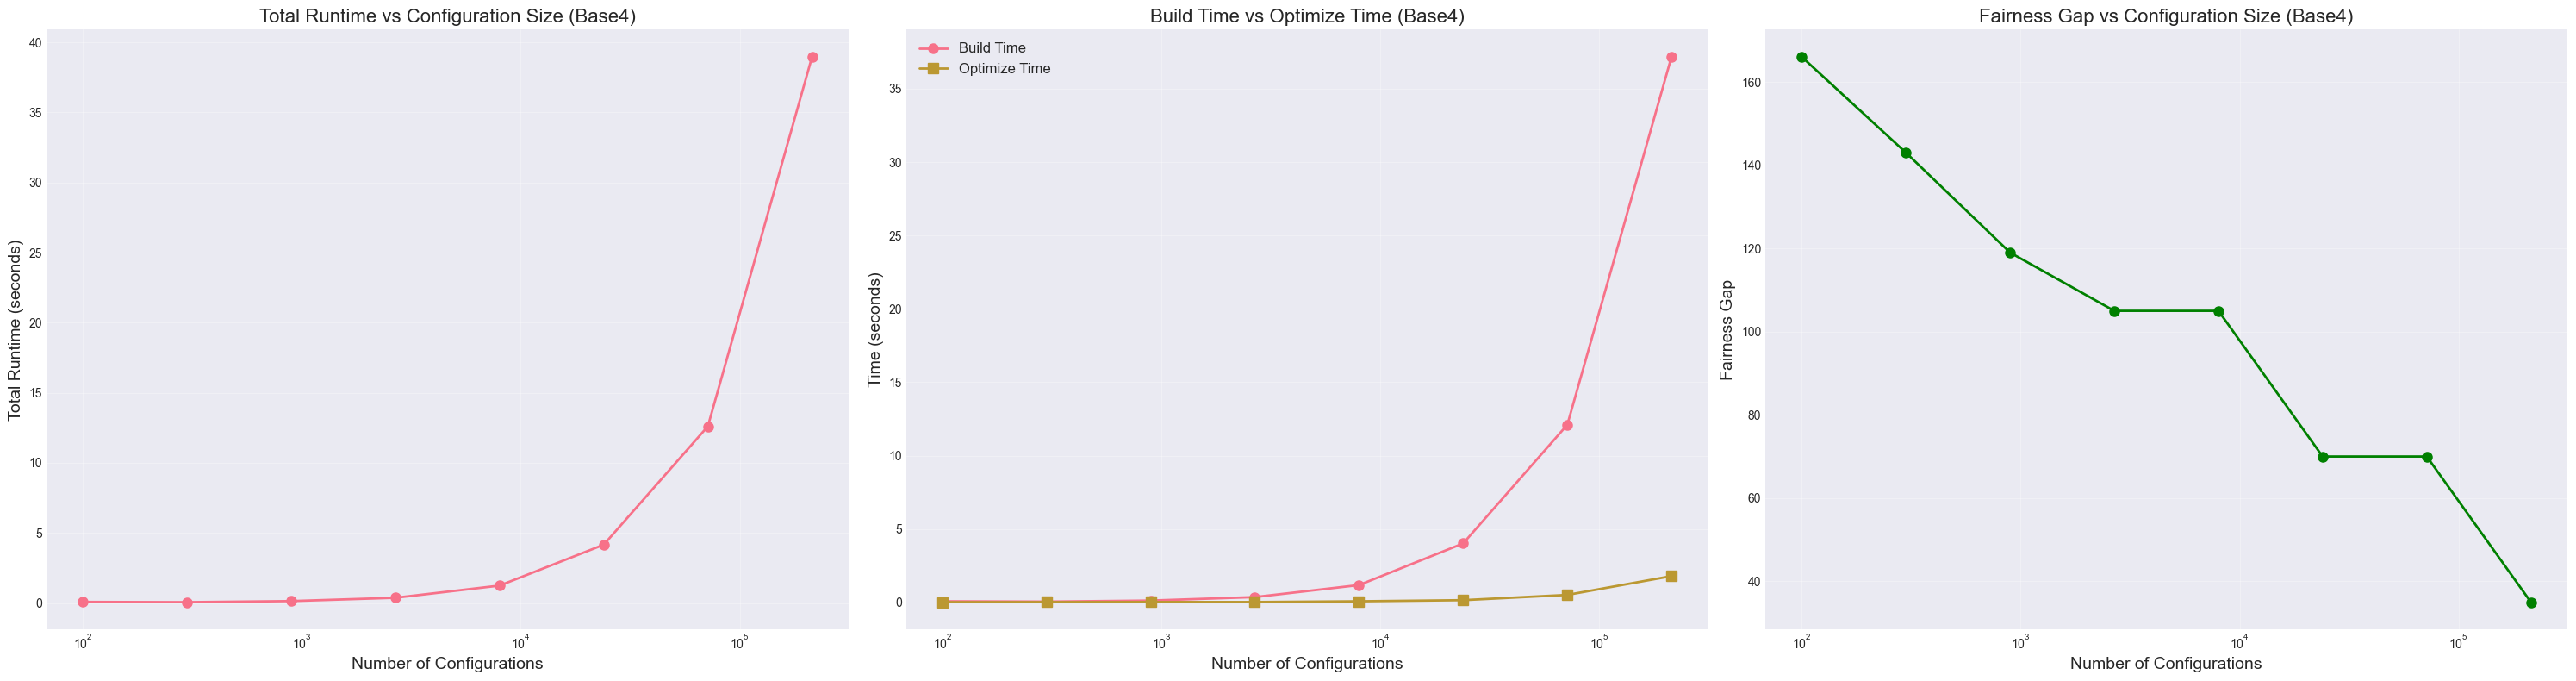


📊 Comprehensive Analysis Summary (Base4):
 Config Size  Total Time (s)  Build Time (s)  Optimize Time (s)  Fairness Gap  Variables  Constraints
         100        0.079098        0.069822           0.008544           166          0            0
         299        0.060475        0.046347           0.013543           143          0            0
         894        0.137986        0.118276           0.018940           119          0            0
        2675        0.373824        0.355383           0.017747           105          0            0
        8001        1.242545        1.174052           0.067793           105          0            0
       23930        4.159384        4.013198           0.145370            70          0            0
       71571       12.604614       12.099634           0.504209            70          0            0
      214057       38.956286       37.169480           1.786005            35          0            0

📈 Key Performance Metrics (Base4):
Tot

In [48]:
# --- LICENSE ACTIVATION ---
env = gp.Env(params=params)

# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"

# Store results for all bases
all_results = {}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.gpickle"), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- GET ONLY BASE4 FILE ---
config_dir = "./configurations/50"
base_dirs = [d for d in os.listdir(config_dir)
             if d.startswith(f"{FILENAME}-base4") and "t0_5" in d]  # Only base4
base_dirs = sorted(base_dirs)

print(f"Found {len(base_dirs)} base configurations (base4 only): {base_dirs}")

# Better timing measurement approach
import time
import psutil
import matplotlib.pyplot as plt

# --- PROCESS ONLY BASE4 ---
for base_folder in base_dirs:
    base_id = base_folder.split("-")[-2]
    print(f"\n🔄 Processing {base_id} for {FILENAME}")

    # Check for configuration file
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if not os.path.exists(config_csv):
        print(f"⚠️ Config file not found for {base_folder}")
        continue

    # --- LOAD FULL CONFIG CSV ---
    df_full = pd.read_csv(config_csv)
    total_configs = len(df_full)

    # Create 8 interval sizes for this base (keep exactly 8)
    min_size = max(1, 100)
    max_size = total_configs
    config_sizes = np.logspace(np.log10(min_size), np.log10(max_size), 8, dtype=int).tolist()
    config_sizes = sorted(list(set(config_sizes)))  # Remove duplicates and sort

    print(f"Config sizes for {base_id}: {config_sizes}")

    fairness_results = []
    solve_times = []
    detailed_timings = []

    # --- LOOP OVER CONFIG SIZES ---
    for NUM_CONFIGS in config_sizes:
        NUM_CONFIGS = int(NUM_CONFIGS)
        print(f"  🔁 Solving for NUM_CONFIGS = {NUM_CONFIGS}")

        df = df_full.head(NUM_CONFIGS)
        configs = []
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
            configs.append(cfg)

        # --- COVERAGE MATRIX ---
        b = {}
        for c_idx, config in enumerate(configs):
            for t, zone in enumerate(config):
                coverage = {zone} | adjacency.get(zone, set())
                for z in coverage:
                    b[z, t, c_idx] = 1

        # --- TIMING IMPROVEMENTS ---
        timing_details = {}
        
        # 1. Measure total time including model creation
        full_start = time.time()
        
        # 2. Build model
        build_start = time.time()
        model = gp.Model(env=env)
        λ = model.addVars(NUM_CONFIGS, vtype=gp.GRB.BINARY, name="lambda")
        y = model.addVars(zones, vtype=gp.GRB.INTEGER, name="y")
        z = model.addVar(vtype=gp.GRB.INTEGER, name="z")

        model.addConstr(gp.quicksum(λ[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count")

        for i in zones:
            model.addConstr(
                y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(NUM_CONFIGS) for t in range(T)),
                f"coverage_{i}"
            )

        for i in zones:
            for j in zones:
                model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")

        model.setObjective(z, gp.GRB.MINIMIZE)
        timing_details['build_time'] = time.time() - build_start
        timing_details['num_vars'] = model.numVars
        timing_details['num_constraints'] = model.numConstrs
        
        # 3. Set up Gurobi settings for better timing
        model.setParam("OutputFlag", 1)  # Enable output to see what's happening
        model.setParam("TimeLimit", 600)  # Set time limit to 10 minutes
        model.setParam("MIPGap", 0.01)  # Set small gap to avoid excessive time
        
        # 4. Optimize with multiple timing measurements
        optimize_start = time.time()
        try:
            model.optimize()
            optimize_time = time.time() - optimize_start
            timing_details['optimize_time'] = optimize_time
            timing_details['status'] = model.status
            
            # Check if solution found
            if model.status == gp.GRB.OPTIMAL:
                fairness_gap = int(z.X)
                timing_details['solution_found'] = True
            elif model.status == gp.GRB.TIME_LIMIT:
                fairness_gap = int(z.X) if hasattr(z, 'X') else -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = "TIME LIMIT REACHED"
            else:
                fairness_gap = -1
                timing_details['solution_found'] = False
                timing_details['status_message'] = f"Status: {model.status}"
                
        except Exception as e:
            optimize_time = time.time() - optimize_start
            fairness_gap = -1
            timing_details['error'] = str(e)
            timing_details['solution_found'] = False
        
        timing_details['total_time'] = time.time() - full_start
        
        print(f"    ✅ Fairness gap: {fairness_gap}")
        print(f"    ⏱️ Build time: {timing_details['build_time']:.2f}s")
        print(f"    ⏱️ Optimize time: {timing_details['optimize_time']:.2f}s") 
        print(f"    ⏱️ Total time: {timing_details['total_time']:.2f}s")
        print(f"    📊 Model stats: {model.numVars} vars, {model.numConstrs} constraints")
        print(f"    -----------------------------------------------------------------------")
        print(f"    -----------------------------------------------------------------------")
        print("\n")

        fairness_results.append(fairness_gap)
        solve_times.append(timing_details['total_time'])
        detailed_timings.append(timing_details)

        model.dispose()
    
    # Store results for this base
    all_results[base_id] = {
        'config_sizes': config_sizes,
        'fairness_gaps': fairness_results,
        'solve_times': solve_times,
        'detailed_timings': detailed_timings  # Store detailed timing info
    }

# --- COMPREHENSIVE VISUALIZATION FOR BASE4 ---

# Get the actual key for base4 data
base4_key = list(all_results.keys())[0]  # Get the first and only key
print(f"Using base4 key: {base4_key}")

# Extract data for base4
base4_data = all_results[base4_key]
config_sizes = base4_data['config_sizes']
total_times = base4_data['solve_times']
build_times = [t['build_time'] for t in base4_data['detailed_timings']]
optimize_times = [t['optimize_time'] for t in base4_data['detailed_timings']]
fairness_gaps = base4_data['fairness_gaps']
num_vars = [t['num_vars'] for t in base4_data['detailed_timings']]
num_constraints = [t['num_constraints'] for t in base4_data['detailed_timings']]

# Create figure with 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot 1: Total Time vs Configuration Size
ax1.plot(config_sizes, total_times, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Total Runtime (seconds)', fontsize=14)
ax1.set_title('Total Runtime vs Configuration Size (Base4)', fontsize=16)
ax1.grid(True, alpha=0.3)

# Plot 2: Build Time vs Optimize Time
ax2.plot(config_sizes, build_times, 'o-', linewidth=2, markersize=8, label='Build Time')
ax2.plot(config_sizes, optimize_times, 's-', linewidth=2, markersize=8, label='Optimize Time')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Time (seconds)', fontsize=14)
ax2.set_title('Build Time vs Optimize Time (Base4)', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Fairness Gap vs Configuration Size
ax3.plot(config_sizes, fairness_gaps, 'o-', linewidth=2, markersize=8, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Fairness Gap', fontsize=14)
ax3.set_title('Fairness Gap vs Configuration Size (Base4)', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('base4_analysis_simple.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table
summary_table = pd.DataFrame({
    'Config Size': config_sizes,
    'Total Time (s)': total_times,
    'Build Time (s)': build_times,
    'Optimize Time (s)': optimize_times,
    'Fairness Gap': fairness_gaps,
    'Variables': num_vars,
    'Constraints': num_constraints
})

print("\n📊 Comprehensive Analysis Summary (Base4):")
print(summary_table.to_string(index=False))

# Save summary to CSV
summary_table.to_csv('base4_analysis_simple.csv', index=False)

# Additional Statistical Analysis
print("\n📈 Key Performance Metrics (Base4):")
if len(total_times) > 0 and total_times[0] > 0:
    total_runtime_ratio = total_times[-1] / total_times[0]
    print(f"Total runtime ratio (largest/smallest): {total_runtime_ratio:.2f}x")
else:
    print("Total runtime ratio: N/A")

fairness_improvement = fairness_gaps[0] - fairness_gaps[-1]
print(f"Fairness improvement: {fairness_improvement}")

if len(build_times) > 0 and build_times[0] > 0:
    build_time_ratio = build_times[-1] / build_times[0]
    print(f"Build time scaling: {build_time_ratio:.2f}x")
else:
    print("Build time scaling: N/A")

if len(optimize_times) > 0 and optimize_times[0] > 0:
    optimize_time_ratio = optimize_times[-1] / optimize_times[0]
    print(f"Optimize time scaling: {optimize_time_ratio:.2f}x")
else:
    print("Optimize time scaling: N/A")

# Calculate average runtime per 100k configs safely
if len(total_times) > 0 and all(c > 0 for c in config_sizes):
    avg_runtime_per_100k = np.mean([t/(c/100000) for t, c in zip(total_times, config_sizes)])
    print(f"Average runtime per 100k configs: {avg_runtime_per_100k:.2f}s")
else:
    print("Average runtime per 100k configs: N/A")

# Clean up
env.dispose()

# STEP 3 >>> Implement binarization - Define a reasonable upper bound (T+1) for how many times a configuration can occur (like 3, 5, 10, etc.), implement the unary expansion technique you described, and compare this formulation with the original model in terms of: 
#### Number of variables, Solution quality, Computation time


#### For Binarization

	•	The key insight in your binarization technique is transforming integer variables Q (representing how many times a configuration occurs) into binary variables using:
	•	Q = 0×Z₀ + 1×Z₁ + 2×Z₂ + ... + T×Zₜ
	•	With the constraint: Z₀ + Z₁ + Z₂ + ... + Zₜ = 1 (exactly one binary variable is selected)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu

Solving original model...
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 1051 columns and 27999 nonzeros
Model fingerprint: 0x8ae2c180
Variable types: 0 continuous, 1051 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 4e+01]
Presolve removed 1743 rows and 671 columns
Presolve time: 0.02s
Presolved: 808 rows, 380 columns, 9201 nonzeros
Variable types: 0 continuous, 380 integer (100 binary)
Found heuristic solution: objective

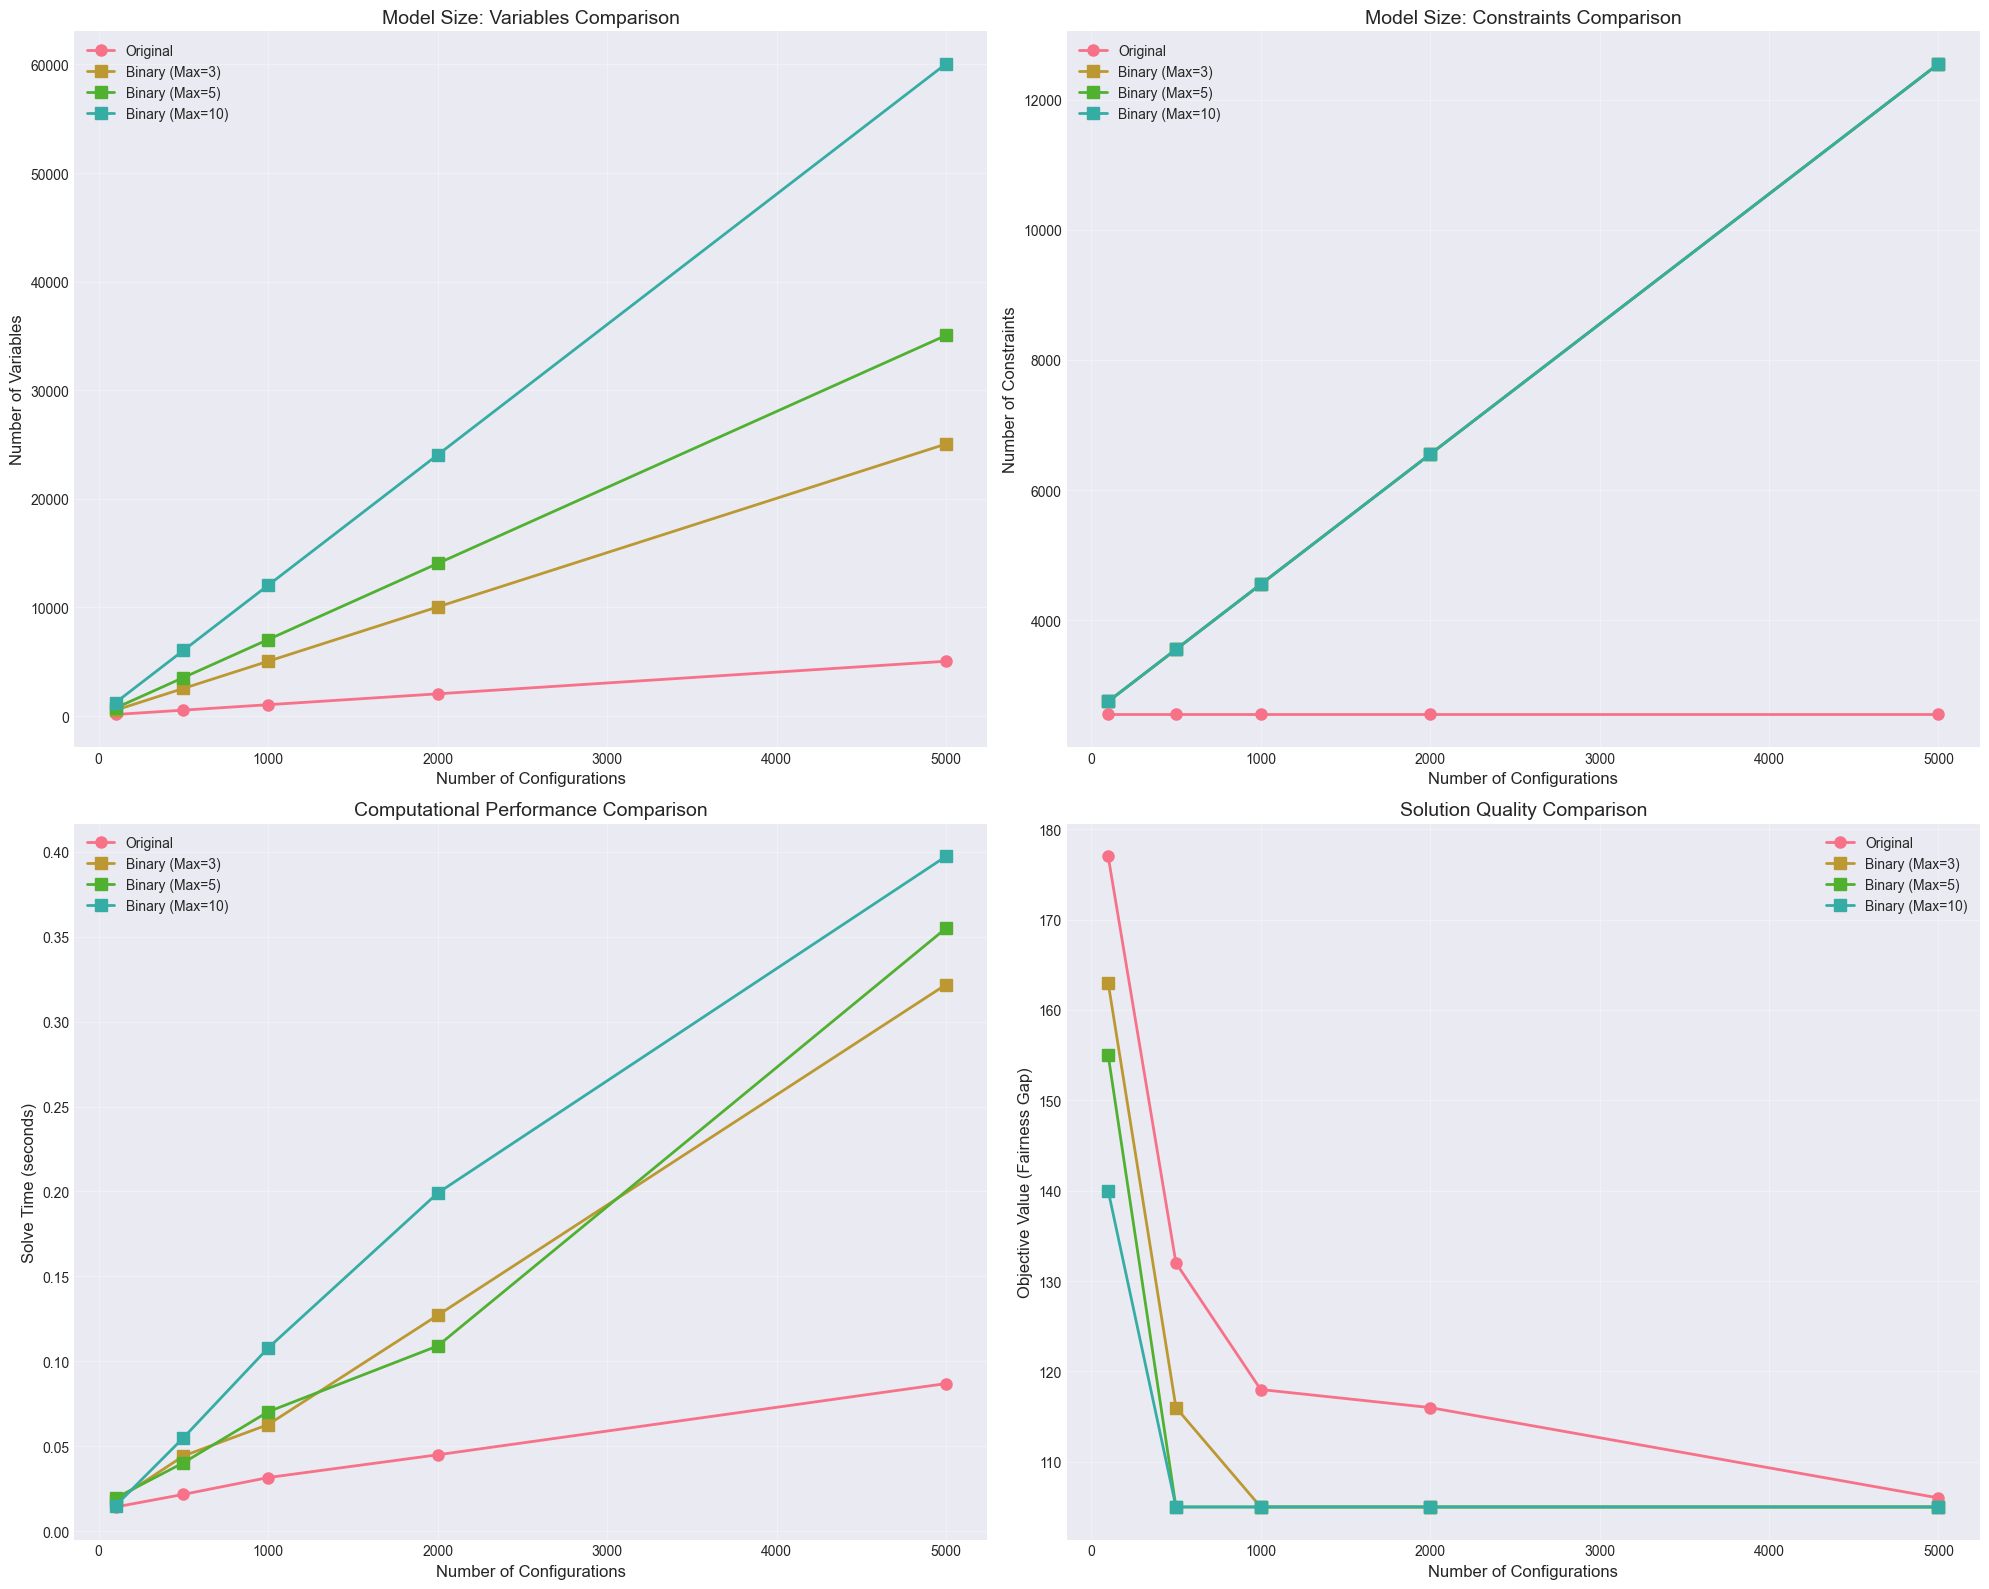


=== SCALING ANALYSIS SUMMARY ===
 config_size  freq_bound  orig_vars  bin_vars  orig_constrs  bin_constrs  orig_time  bin_time  orig_obj  bin_obj
         100           3        151       551          2551         2751   0.014162  0.017908     177.0    163.0
         100           5        151       751          2551         2751   0.013655  0.019449     177.0    155.0
         100          10        151      1251          2551         2751   0.018183  0.014980     177.0    140.0
         500           3        551      2551          2551         3551   0.021581  0.044225     132.0    116.0
         500           5        551      3551          2551         3551   0.022024  0.040220     132.0    105.0
         500          10        551      6051          2551         3551   0.022826  0.054962     132.0    105.0
        1000           3       1051      5051          2551         4551   0.031495  0.062712     118.0    105.0
        1000           5       1051      7051          2551   

In [73]:
# Configuration-Based Unary Binarization (Step 3) with Analysis

# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
CONFIG_CSV = "./configurations/50/50-3004-6-7-35-base0_t0_5/configs.csv"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 5  # A configuration can occur 0-5 times

# --- LOAD GRAPH ---
env = gp.Env(params=params)
model_original = gp.Model(env=env)
model_binarized = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD CONFIGS ---
NUM_CONFIGS = 1000  # Test with reasonable number
df = pd.read_csv(CONFIG_CSV).head(NUM_CONFIGS)
configs = []
for _, row in df.iterrows():
    cfg = []
    for t in range(T):
        cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
    configs.append(cfg)

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
b = {}
for c_idx, config in enumerate(configs):
    for t, zone in enumerate(config):
        coverage = {zone} | adjacency.get(zone, set())
        for z in coverage:
            b[z, t, c_idx] = 1

# --- ORIGINAL MODEL ---
# Variables
λ_original = model_original.addVars(NUM_CONFIGS, vtype=GRB.BINARY, name="lambda_original")
y_original = model_original.addVars(zones, vtype=GRB.INTEGER, name="y_original")  
z_original = model_original.addVar(vtype=GRB.INTEGER, name="z_original")

# Constraints
model_original.addConstr(gp.quicksum(λ_original[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES, "ambulance_count_original")

for i in zones:
    model_original.addConstr(
        y_original[i] == gp.quicksum(b.get((i, t, c), 0) * λ_original[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_original_{i}"
    )

for i in zones:
    for j in zones:
        model_original.addConstr(z_original >= y_original[i] - y_original[j], f"fair_original_{i}_{j}")

model_original.setObjective(z_original, GRB.MINIMIZE)

# --- BINARIZED MODEL (Unary Expansion) ---
# Variables
# Z[c, k]: binary variable indicating if configuration c occurs k times
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_binarized.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

# q[c]: integer variable representing how many times configuration c occurs
q = model_binarized.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

y_binarized = model_binarized.addVars(zones, vtype=GRB.INTEGER, name="y_binarized")
z_binarized = model_binarized.addVar(vtype=GRB.INTEGER, name="z_binarized")

# Constraints
# One-hot constraint: Each configuration occurs exactly once with some frequency
for c in range(NUM_CONFIGS):
    model_binarized.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# Link q to Z: q[c] = sum(k * Z[c,k])
for c in range(NUM_CONFIGS):
    model_binarized.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# Total ambulance count constraint
model_binarized.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_binarized"
)

# Coverage constraints
for i in zones:
    model_binarized.addConstr(
        y_binarized[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binarized_{i}"
    )

# Fairness constraints
for i in zones:
    for j in zones:
        model_binarized.addConstr(z_binarized >= y_binarized[i] - y_binarized[j], f"fair_binarized_{i}_{j}")

model_binarized.setObjective(z_binarized, GRB.MINIMIZE)

# --- SOLVE BOTH MODELS AND COMPARE ---
print("\nSolving original model...")
start_original = time.time()
model_original.optimize()
time_original = time.time() - start_original

print("\nSolving binarized model...")
start_binarized = time.time()
model_binarized.optimize()
time_binarized = time.time() - start_binarized

# --- RESULTS COMPARISON ---
print("\n=== COMPARISON RESULTS ===")
print(f"{'Metric':<25} | {'Original Model':<15} | {'Binarized Model':<15}")
print("-" * 60)
print(f"{'Number of Variables':<25} | {model_original.numVars:<15} | {model_binarized.numVars:<15}")
print(f"{'Number of Constraints':<25} | {model_original.numConstrs:<15} | {model_binarized.numConstrs:<15}")
print(f"{'Objective Value':<25} | {model_original.objVal:<15.2f} | {model_binarized.objVal:<15.2f}")
print(f"{'Solve Time (seconds)':<25} | {time_original:<15.2f} | {time_binarized:<15.2f}")

print("\n=== SELECTED CONFIGURATION FREQUENCIES ===")
print("Original Model (binary selection):")
selected_original = [(c, λ_original[c].X) for c in range(NUM_CONFIGS) if λ_original[c].X > 0.5]
print(f"Number of selected configs: {len(selected_original)}")

print("\nBinarized Model (unary expansion):")
selected_binarized = [(c, int(q[c].X)) for c in range(NUM_CONFIGS) if q[c].X > 0.5]
print(f"Number of configurations with frequency > 0: {len(selected_binarized)}")
for c, freq in selected_binarized:
    print(f"  Config {c}: {freq} times")

# --- SCALING ANALYSIS ---
# Test with different config sizes and MAX_CONFIG_FREQUENCY values
scaling_results = []
config_sizes = [100, 500, 1000, 2000, 5000]
frequency_bounds = [3, 5, 10]

for size in config_sizes:
    for freq_bound in frequency_bounds:
        # Reset models
        model_orig_scale = gp.Model(env=env)
        model_bin_scale = gp.Model(env=env)
        
        # Use subset of configs
        df_subset = pd.read_csv(CONFIG_CSV).head(size)
        configs_subset = []
        for _, row in df_subset.iterrows():
            cfg = []
            for t in range(T):
                cfg.append((row[f"t{t}_x"], row[f"t{t}_y"]))
            configs_subset.append(cfg)
        
        # Build coverage matrix
        b_subset = {}
        for c_idx, config in enumerate(configs_subset):
            for t, zone in enumerate(config):
                coverage = {zone} | adjacency.get(zone, set())
                for z in coverage:
                    b_subset[z, t, c_idx] = 1
        
        # Original model
        λ_scale = model_orig_scale.addVars(size, vtype=GRB.BINARY, name="lambda")
        y_scale = model_orig_scale.addVars(zones, vtype=GRB.INTEGER, name="y")
        z_scale = model_orig_scale.addVar(vtype=GRB.INTEGER, name="z")
        
        model_orig_scale.addConstr(gp.quicksum(λ_scale[c] for c in range(size)) == NUM_AMBULANCES)
        
        for i in zones:
            model_orig_scale.addConstr(
                y_scale[i] == gp.quicksum(b_subset.get((i, t, c), 0) * λ_scale[c] for c in range(size) for t in range(T))
            )
        
        for i in zones:
            for j in zones:
                model_orig_scale.addConstr(z_scale >= y_scale[i] - y_scale[j])
        
        model_orig_scale.setObjective(z_scale, GRB.MINIMIZE)
        
        # Binarized model
        Z_scale = {}
        for c in range(size):
            for k in range(freq_bound + 1):
                Z_scale[c, k] = model_bin_scale.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")
        
        q_scale = model_bin_scale.addVars(size, vtype=GRB.INTEGER, name="q")
        y_scale_bin = model_bin_scale.addVars(zones, vtype=GRB.INTEGER, name="y")
        z_scale_bin = model_bin_scale.addVar(vtype=GRB.INTEGER, name="z")
        
        for c in range(size):
            model_bin_scale.addConstr(gp.quicksum(Z_scale[c, k] for k in range(freq_bound + 1)) == 1)
            model_bin_scale.addConstr(q_scale[c] == gp.quicksum(k * Z_scale[c, k] for k in range(freq_bound + 1)))
        
        model_bin_scale.addConstr(gp.quicksum(q_scale[c] for c in range(size)) == NUM_AMBULANCES)
        
        for i in zones:
            model_bin_scale.addConstr(
                y_scale_bin[i] == gp.quicksum(b_subset.get((i, t, c), 0) * q_scale[c] for c in range(size) for t in range(T))
            )
        
        for i in zones:
            for j in zones:
                model_bin_scale.addConstr(z_scale_bin >= y_scale_bin[i] - y_scale_bin[j])
        
        model_bin_scale.setObjective(z_scale_bin, GRB.MINIMIZE)
        
        # Solve and record results
        start_orig = time.time()
        model_orig_scale.optimize()
        time_orig = time.time() - start_orig
        
        start_bin = time.time()
        model_bin_scale.optimize()
        time_bin = time.time() - start_bin
        
        scaling_results.append({
            'config_size': size,
            'freq_bound': freq_bound,
            'orig_vars': model_orig_scale.numVars,
            'bin_vars': model_bin_scale.numVars,
            'orig_constrs': model_orig_scale.numConstrs,
            'bin_constrs': model_bin_scale.numConstrs,
            'orig_time': time_orig,
            'bin_time': time_bin,
            'orig_obj': model_orig_scale.objVal,
            'bin_obj': model_bin_scale.objVal
        })
        
        model_orig_scale.dispose()
        model_bin_scale.dispose()

# Convert to DataFrame for better visualization
import pandas as pd
scaling_df = pd.DataFrame(scaling_results)

# --- VISUALIZATION ---
import matplotlib.pyplot as plt

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Variables comparison
# Get original data once
orig_sizes = scaling_df['config_size'].unique()
orig_vars = scaling_df.groupby('config_size')['orig_vars'].first()
axes[0,0].plot(orig_sizes, orig_vars, 'o-', label='Original', linewidth=2, markersize=8)

# Plot binary data for each frequency
for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq]
    axes[0,0].plot(subset['config_size'], subset['bin_vars'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Configurations', fontsize=12)
axes[0,0].set_ylabel('Number of Variables', fontsize=12)
axes[0,0].set_title('Model Size: Variables Comparison', fontsize=14)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Constraints comparison
orig_constrs = scaling_df.groupby('config_size')['orig_constrs'].first()
axes[0,1].plot(orig_sizes, orig_constrs, 'o-', label='Original', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq]
    axes[0,1].plot(subset['config_size'], subset['bin_constrs'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Number of Configurations', fontsize=12)
axes[0,1].set_ylabel('Number of Constraints', fontsize=12)
axes[0,1].set_title('Model Size: Constraints Comparison', fontsize=14)
axes[0,1].legend(fontsize=10)
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Solve time comparison
orig_time = scaling_df.groupby('config_size')['orig_time'].first()
axes[1,0].plot(orig_sizes, orig_time, 'o-', label='Original', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq]
    axes[1,0].plot(subset['config_size'], subset['bin_time'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Number of Configurations', fontsize=12)
axes[1,0].set_ylabel('Solve Time (seconds)', fontsize=12)
axes[1,0].set_title('Computational Performance Comparison', fontsize=14)
axes[1,0].legend(fontsize=10)
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Objective value comparison
orig_obj = scaling_df.groupby('config_size')['orig_obj'].first()
axes[1,1].plot(orig_sizes, orig_obj, 'o-', label='Original', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq]
    axes[1,1].plot(subset['config_size'], subset['bin_obj'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Number of Configurations', fontsize=12)
axes[1,1].set_ylabel('Objective Value (Fairness Gap)', fontsize=12)
axes[1,1].set_title('Solution Quality Comparison', fontsize=14)
axes[1,1].legend(fontsize=10)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('binarization_comparison_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

# --- SUMMARY STATISTICS ---
print("\n=== SCALING ANALYSIS SUMMARY ===")
print(scaling_df.to_string(index=False))

print("\n=== KEY INSIGHTS ===")
print(f"Variable increase factor: {scaling_df['bin_vars'].mean() / scaling_df['orig_vars'].mean():.2f}x")
print(f"Constraint increase factor: {scaling_df['bin_constrs'].mean() / scaling_df['orig_constrs'].mean():.2f}x")
print(f"Average solve time ratio (binary/original): {(scaling_df['bin_time'] / scaling_df['orig_time']).mean():.2f}x")

# Clean up
model_original.dispose()
model_binarized.dispose()
env.dispose()

# STEP4 >>> Use the binarized model for consistency constraints - This is the most challenging part where you need to figure out how to write the consistency constraints using binary variables. The constraint ensures that between consecutive time periods, you cannot move more than a certain number of ambulances.

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu

Solving binarized model with consistency constraints...
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 23106 rows, 53896 columns and 397841 nonzeros
Model fingerprint: 0x6abafe68
Variable types: 0 continuous, 53896 integer (40000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 805 rows and 11143 columns
Presolve time: 0.24s
Presolved: 22301 rows, 42753 columns, 321559 nonzeros
Variable types: 0 continuous, 42753 integer (300

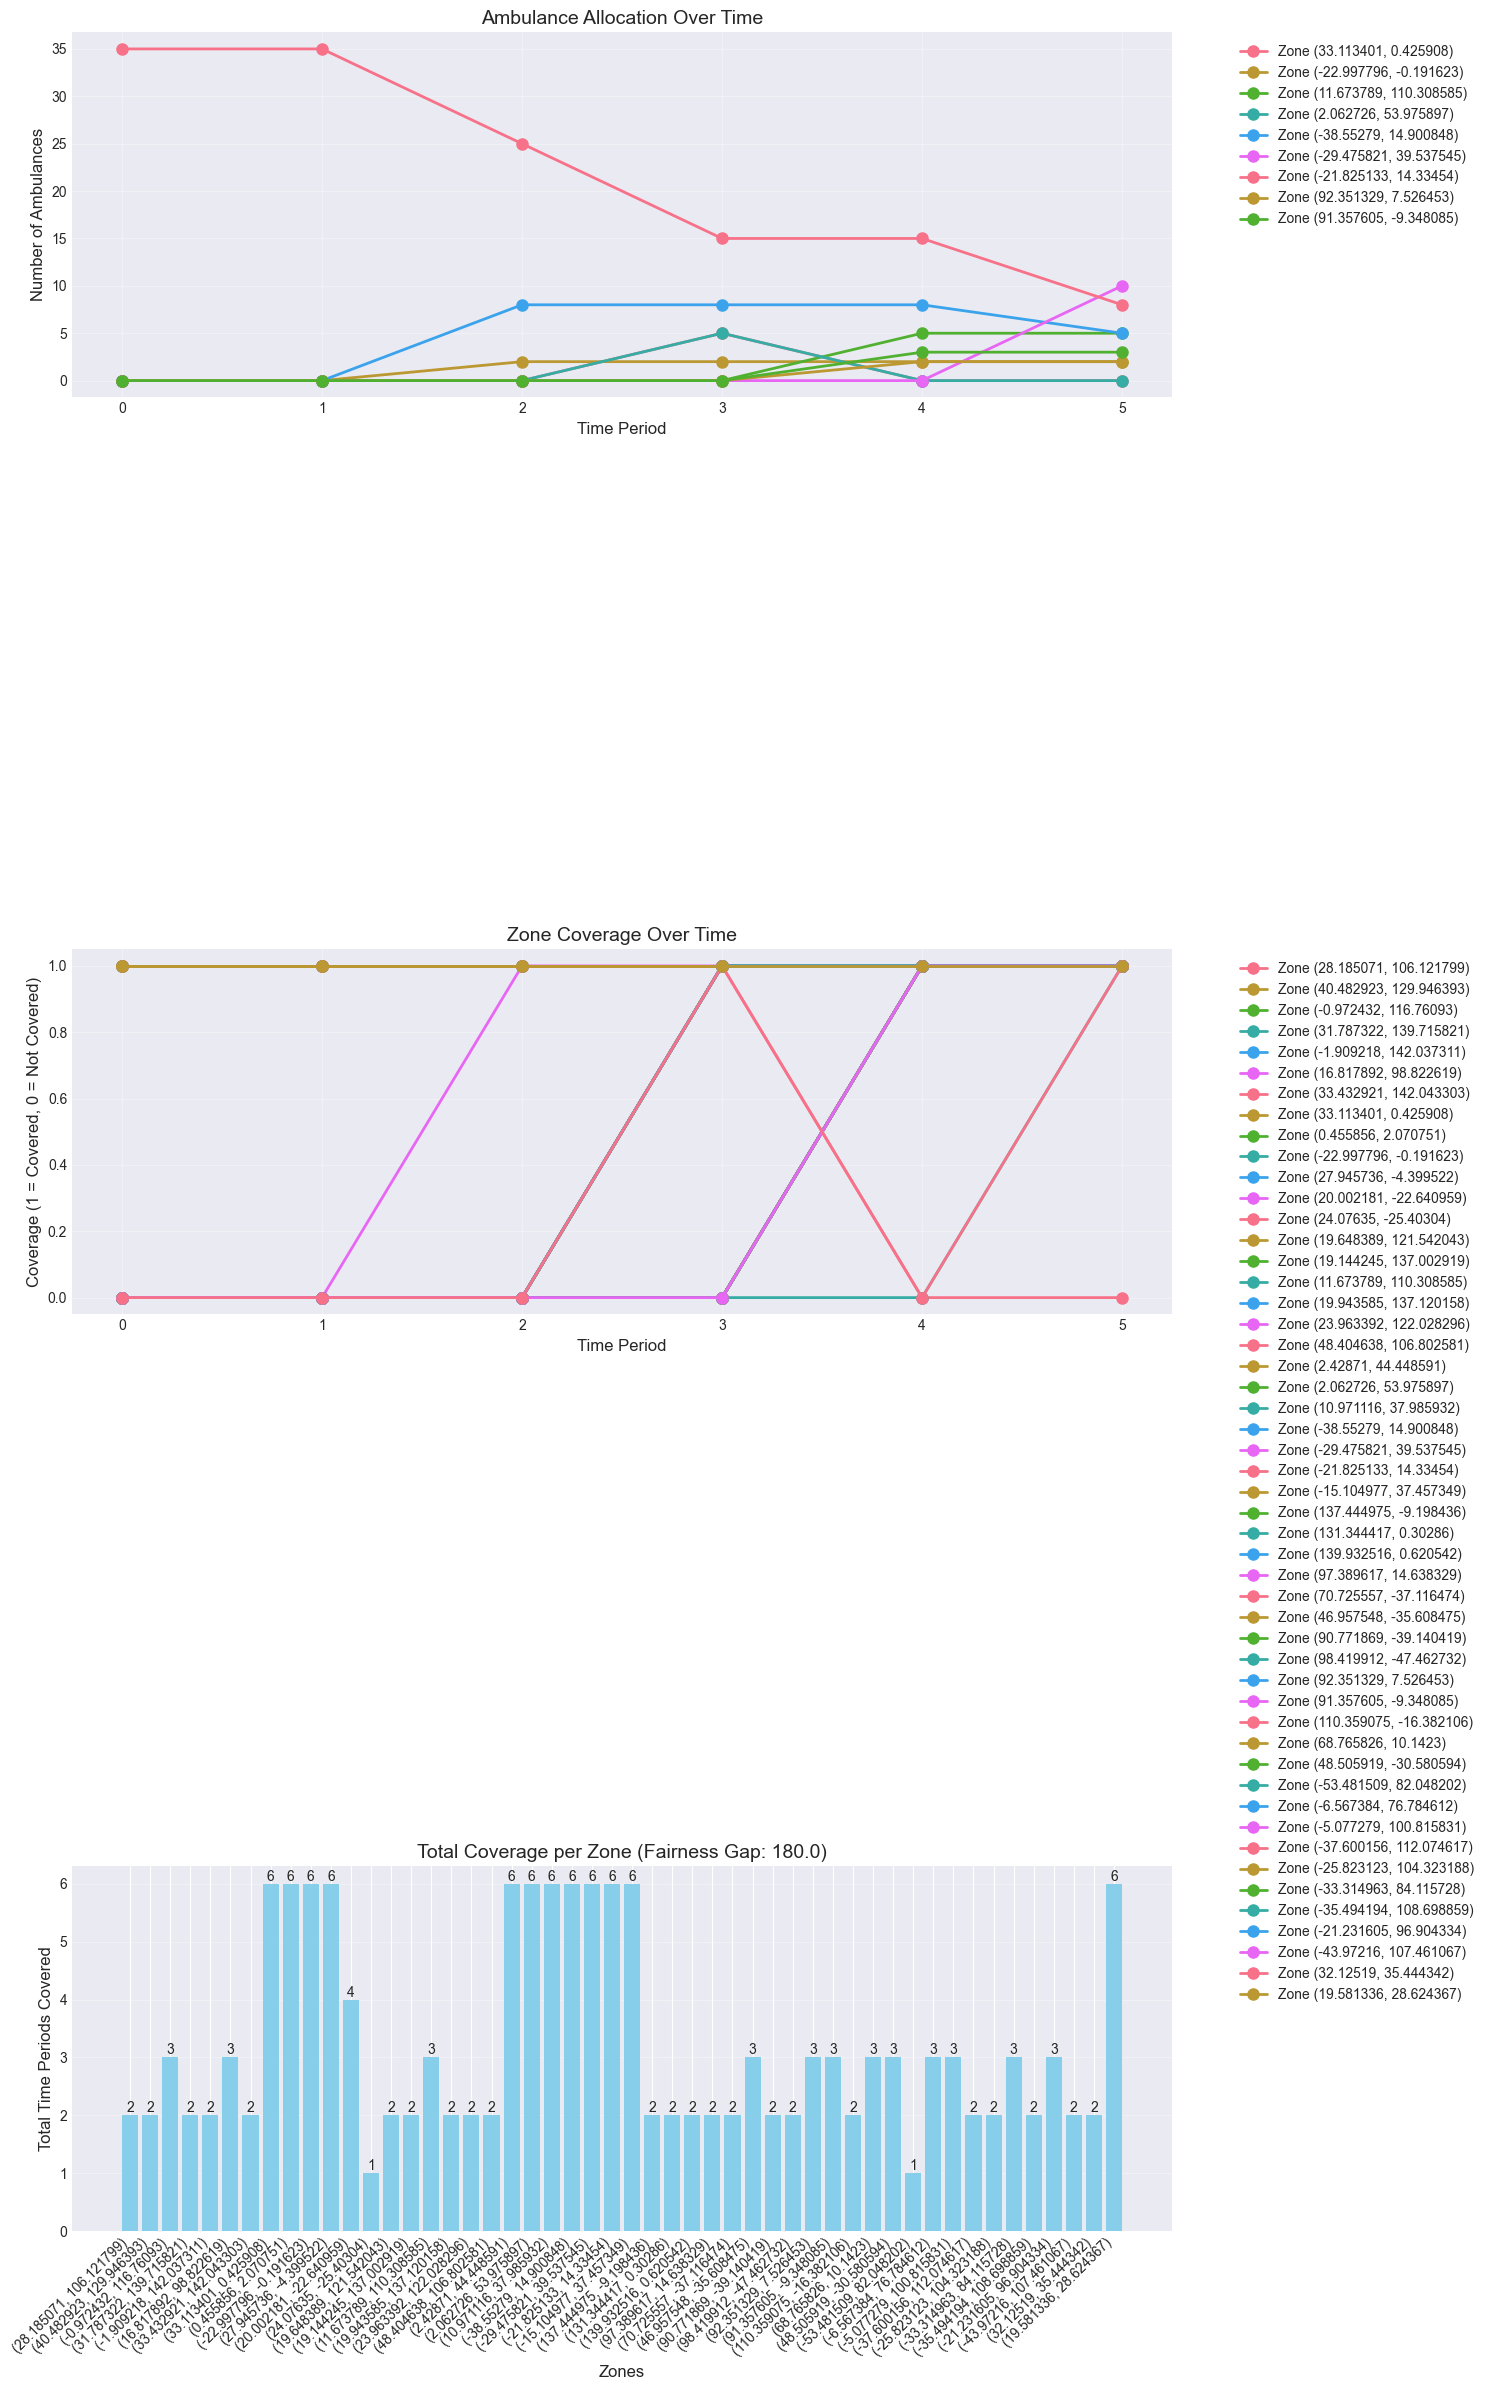


=== COVERAGE STATISTICS ===
Zone (28.185071, 106.121799): Covered for 2 time periods
Zone (40.482923, 129.946393): Covered for 2 time periods
Zone (-0.972432, 116.76093): Covered for 3 time periods
Zone (31.787322, 139.715821): Covered for 2 time periods
Zone (-1.909218, 142.037311): Covered for 2 time periods
Zone (16.817892, 98.822619): Covered for 3 time periods
Zone (33.432921, 142.043303): Covered for 2 time periods
Zone (33.113401, 0.425908): Covered for 6 time periods
Zone (0.455856, 2.070751): Covered for 6 time periods
Zone (-22.997796, -0.191623): Covered for 6 time periods
Zone (27.945736, -4.399522): Covered for 6 time periods
Zone (20.002181, -22.640959): Covered for 4 time periods
Zone (24.07635, -25.40304): Covered for 1 time periods
Zone (19.648389, 121.542043): Covered for 2 time periods
Zone (19.144245, 137.002919): Covered for 2 time periods
Zone (11.673789, 110.308585): Covered for 3 time periods
Zone (19.943585, 137.120158): Covered for 2 time periods
Zone (23.963

In [76]:
# Step 4: Adding Consistency Constraints to Binarized Model with Coverage Visualization

# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
CONFIG_CSV = "./configurations/50/50-3004-6-7-35-base0_t0_5/configs.csv"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 3  # Configurations can occur 0-3 times
MAX_MOVEMENT = 10  # Maximum ambulances that can move between zones per time step

# --- COORDINATE CLEANER (fix float mismatches) ---
def clean_coord(node):
    return tuple(round(float(coord), 6) for coord in node)

# --- LOAD GRAPH ---
env = gp.Env(params=params)
model_binarized_consistent = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)

# Clean all coordinates
adjacency_cleaned = {}
for node, neighbors in G.adjacency():
    cleaned_node = clean_coord(node)
    cleaned_neighbors = set()
    for neighbor in neighbors:
        cleaned_neighbors.add(clean_coord(neighbor))
    adjacency_cleaned[cleaned_node] = cleaned_neighbors

zones = [clean_coord(node) for node in G.nodes]

# --- LOAD CONFIGS ---
NUM_CONFIGS = 10000  # Test with manageable number
df = pd.read_csv(CONFIG_CSV).head(NUM_CONFIGS)
configs = []
for _, row in df.iterrows():
    cfg = []
    for t in range(T):
        cfg.append(clean_coord((row[f"t{t}_x"], row[f"t{t}_y"])))
    configs.append(cfg)

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
b = {}
for c_idx, config in enumerate(configs):
    for t, zone in enumerate(config):
        coverage = {zone} | adjacency_cleaned.get(zone, set())
        for z in coverage:
            b[z, t, c_idx] = 1

# --- BINARIZED MODEL WITH CONSISTENCY CONSTRAINTS ---
# Variables
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_binarized_consistent.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

q = model_binarized_consistent.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

x = {}
for i in zones:
    for t in range(T):
        x[i, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"x_{i}_{t}")

m = {}
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i == j or j in adjacency_cleaned.get(i, set()):
                m[i, j, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"m_{i}_{j}_{t}")

y_binarized = model_binarized_consistent.addVars(zones, vtype=GRB.INTEGER, name="y_binarized")
z_binarized = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name="z_binarized")

model_binarized_consistent.update()

# --- CONSTRAINTS ---
# 1. One-hot constraint
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# 2. Link q to Z
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# 3. Total ambulance count
model_binarized_consistent.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_binarized"
)

# 4. Calculate x[i,t]
for i in zones:
    for t in range(T):
        contributions = []
        for c, config in enumerate(configs):
            if config[t] == i:
                contributions.append(q[c])
        
        if contributions:
            model_binarized_consistent.addConstr(
                x[i, t] == gp.quicksum(contributions),
                f"ambulance_count_{i}_{t}"
            )
        else:
            model_binarized_consistent.addConstr(x[i, t] == 0, f"ambulance_count_{i}_{t}")

# 5. Flow conservation
for t in range(T-1):
    for i in zones:
        leaving = gp.quicksum(m[i, j, t] for j in zones if (i, j, t) in m)
        arriving = gp.quicksum(m[j, i, t] for j in zones if (j, i, t) in m)
        model_binarized_consistent.addConstr(
            x[i, t] + arriving - leaving == x[i, t+1],
            f"flow_conservation_{i}_{t}"
        )

# 6. Movement constraints
for t in range(T-1):
    total_movement = gp.quicksum(m[i, j, t] for (i, j, t_) in m if t_ == t)
    model_binarized_consistent.addConstr(
        total_movement <= MAX_MOVEMENT,
        f"max_movement_{t}"
    )

# 7. Adjacency constraints
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i != j and j not in adjacency_cleaned.get(i, set()):
                if (i, j, t) in m:
                    model_binarized_consistent.addConstr(m[i, j, t] == 0, f"adjacent_{i}_{j}_{t}")

# 8. Coverage constraints
for i in zones:
    model_binarized_consistent.addConstr(
        y_binarized[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binarized_{i}"
    )

# 9. Fairness constraints
for i in zones:
    for j in zones:
        model_binarized_consistent.addConstr(z_binarized >= y_binarized[i] - y_binarized[j], f"fair_binarized_{i}_{j}")

model_binarized_consistent.setObjective(z_binarized, GRB.MINIMIZE)

# --- SOLVE AND ANALYZE ---
print("\nSolving binarized model with consistency constraints...")
start_time = time.time()
model_binarized_consistent.optimize()
solve_time = time.time() - start_time

# --- RESULTS ANALYSIS ---
print("\n=== MODEL STATISTICS ===")
print(f"Number of Variables: {model_binarized_consistent.numVars}")
print(f"Number of Constraints: {model_binarized_consistent.numConstrs}")
print(f"Solve Time: {solve_time:.2f} seconds")
print(f"Fairness Gap: {z_binarized.X}")

# Calculate coverage for each zone at each time step
coverage_by_zone_time = {}
for i in zones:
    for t in range(T):
        # Check if zone i is covered at time t
        has_ambulances = x[i, t].X > 0.5
        neighbor_has_ambulances = False
        for j in adjacency_cleaned.get(i, set()):
            if x[j, t].X > 0.5:
                neighbor_has_ambulances = True
                break
        coverage_by_zone_time[i, t] = 1 if (has_ambulances or neighbor_has_ambulances) else 0

# --- COMPREHENSIVE VISUALIZATION ---
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))

# Plot 1: Ambulance allocation over time
for i in zones:
    ambulance_counts = [int(x[i, t].X) if x[i, t].X > 0.5 else 0 for t in range(T)]
    if any(ambulance_counts):
        ax1.plot(range(T), ambulance_counts, 'o-', label=f'Zone {i}', linewidth=2, markersize=8)

ax1.set_xlabel('Time Period', fontsize=12)
ax1.set_ylabel('Number of Ambulances', fontsize=12)
ax1.set_title('Ambulance Allocation Over Time', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot 2: Coverage over time
for i in zones:
    coverage_values = [coverage_by_zone_time.get((i, t), 0) for t in range(T)]
    ax2.plot(range(T), coverage_values, 'o-', label=f'Zone {i}', linewidth=2, markersize=8)

ax2.set_xlabel('Time Period', fontsize=12)
ax2.set_ylabel('Coverage (1 = Covered, 0 = Not Covered)', fontsize=12)
ax2.set_title('Zone Coverage Over Time', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot 3: Total coverage per zone
total_coverage_per_zone = []
zone_labels = []
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    total_coverage_per_zone.append(total)
    zone_labels.append(str(i))

bars = ax3.bar(range(len(zones)), total_coverage_per_zone, color='skyblue')
ax3.set_xlabel('Zones', fontsize=12)
ax3.set_ylabel('Total Time Periods Covered', fontsize=12)
ax3.set_title(f'Total Coverage per Zone (Fairness Gap: {z_binarized.X})', fontsize=14)
ax3.set_xticks(range(len(zones)))
ax3.set_xticklabels(zone_labels, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('complete_coverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("\n=== COVERAGE STATISTICS ===")
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    print(f"Zone {i}: Covered for {total} time periods")
print(f"\nFairness Gap (max difference in coverage): {z_binarized.X}")

# Clean up
model_binarized_consistent.dispose()
env.dispose()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Loading configurations from 5 bases...
  35: Limiting to 5000 out of 821296 configs
  35: Limiting to 5000 out of 392122 configs
  35: Limiting to 5000 out of 1468840 configs
  35: Limiting to 5000 out of 1595287 configs
  35: Limiting to 5000 out of 214057 configs

Total configurations loaded: 25000
Configurations per base: {'35': np.int64(25000)}
Building coverage matrix...
Creating optimization model...

Solving binarized model with consistency constraints...
Model size: 128896 variables, 0 constraints
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.01
Set parameter MIPFocus to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, 

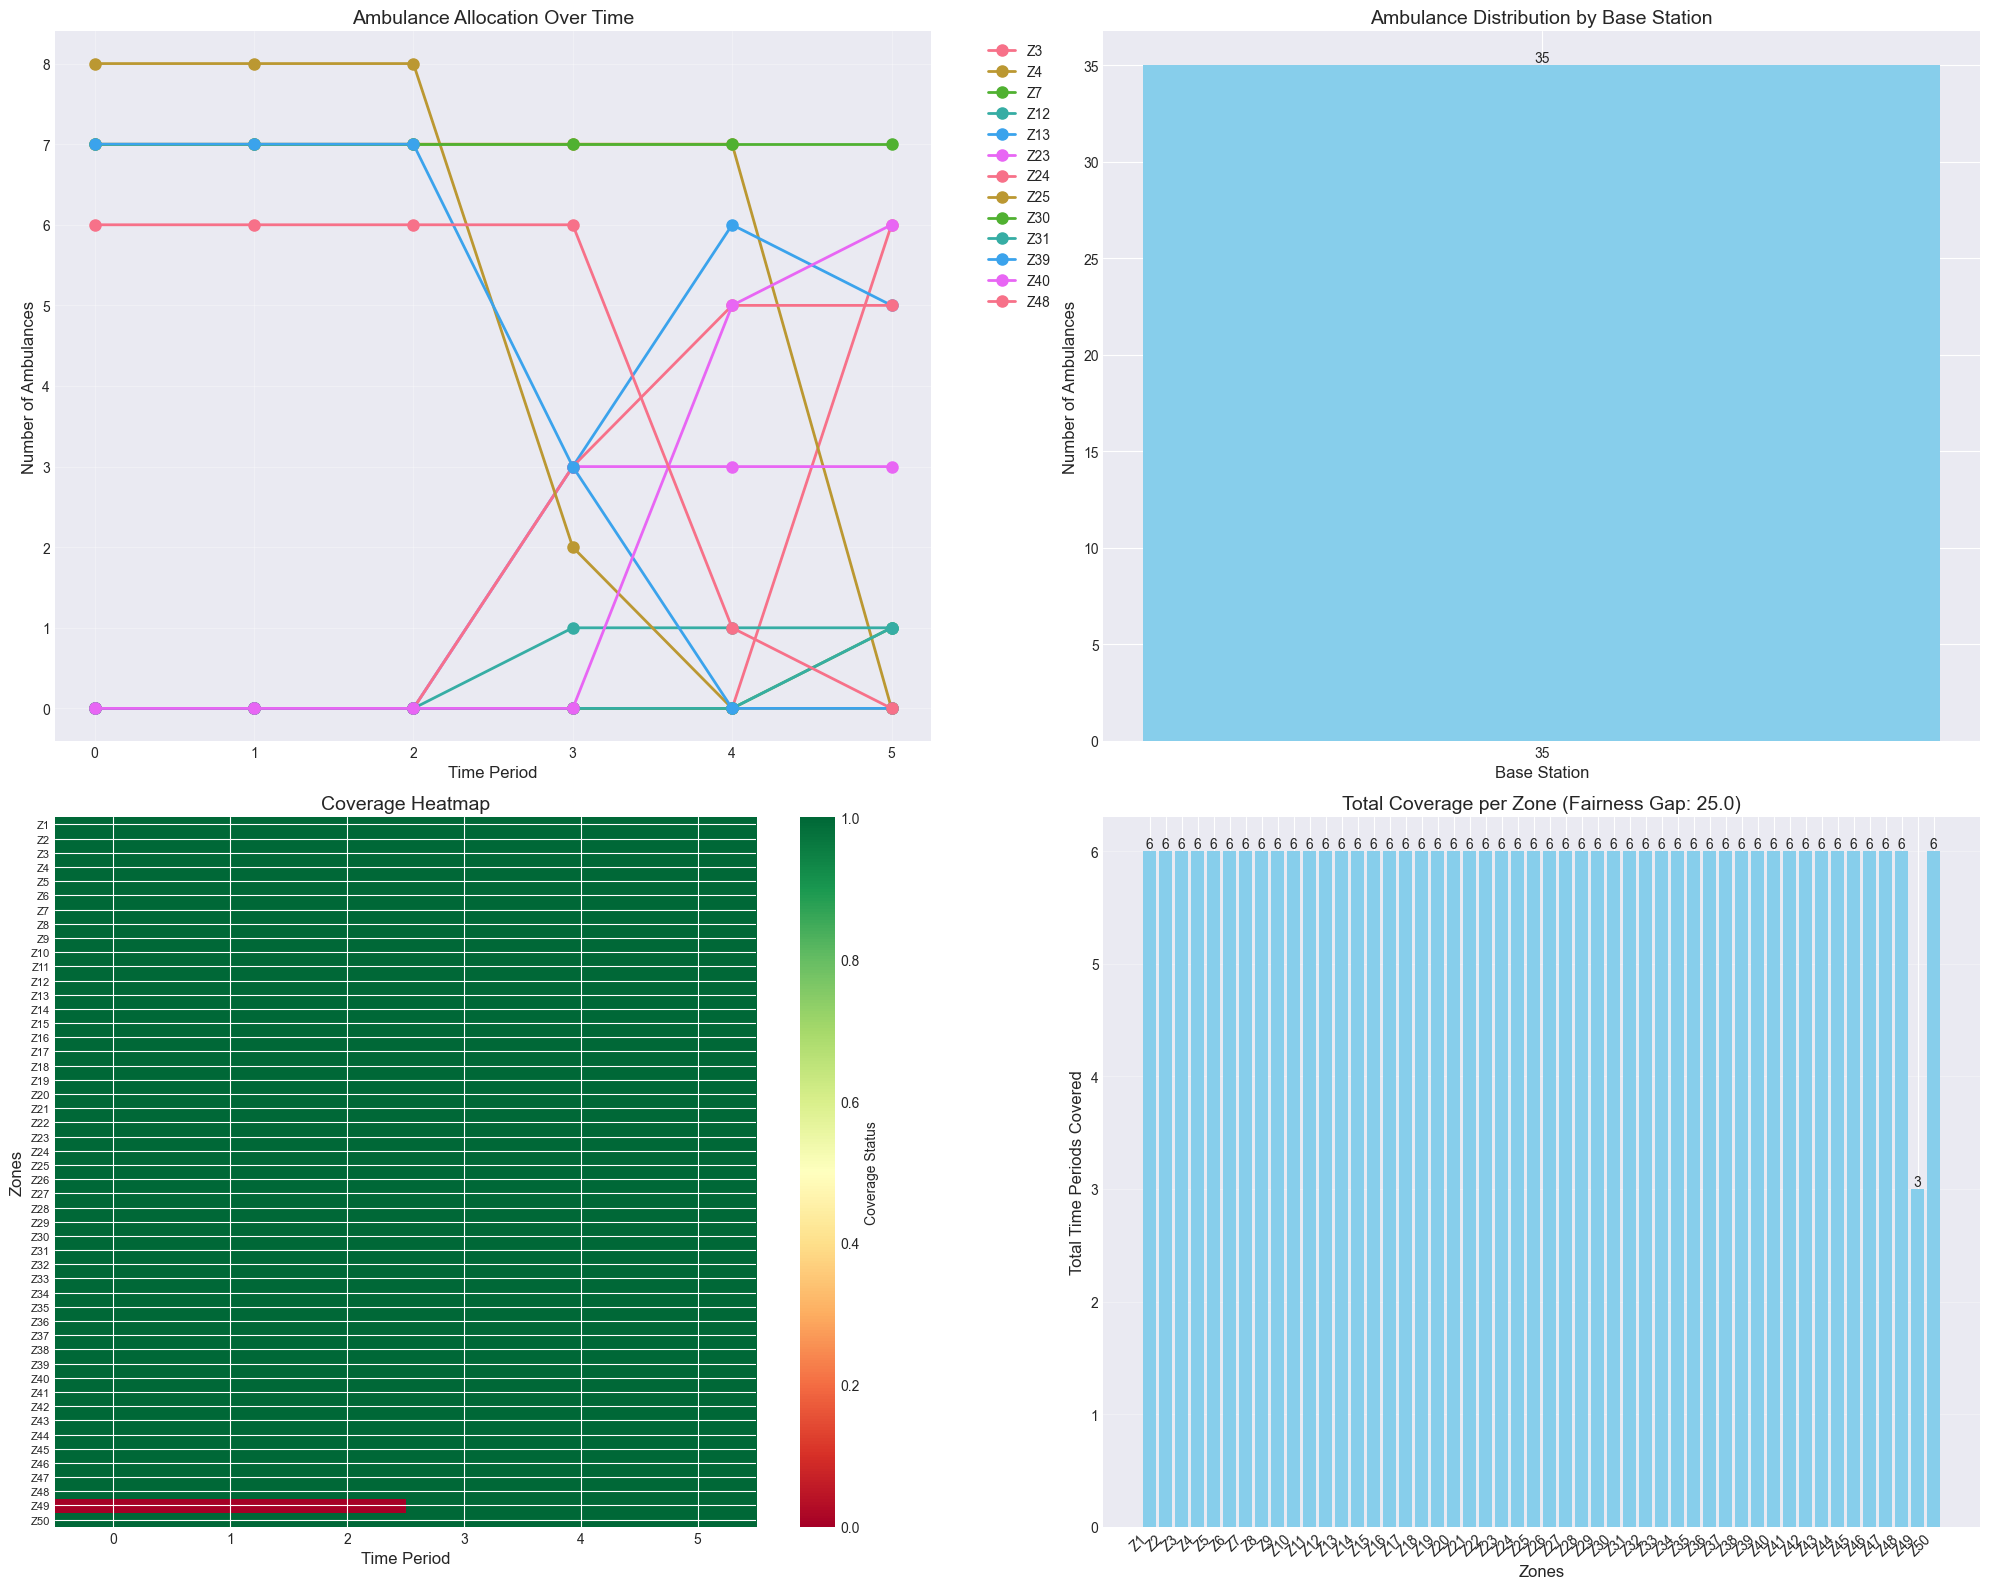


=== COVERAGE STATISTICS ===
Z1: Covered for 6 time periods
Z2: Covered for 6 time periods
Z3: Covered for 6 time periods
Z4: Covered for 6 time periods
Z5: Covered for 6 time periods
Z6: Covered for 6 time periods
Z7: Covered for 6 time periods
Z8: Covered for 6 time periods
Z9: Covered for 6 time periods
Z10: Covered for 6 time periods
Z11: Covered for 6 time periods
Z12: Covered for 6 time periods
Z13: Covered for 6 time periods
Z14: Covered for 6 time periods
Z15: Covered for 6 time periods
Z16: Covered for 6 time periods
Z17: Covered for 6 time periods
Z18: Covered for 6 time periods
Z19: Covered for 6 time periods
Z20: Covered for 6 time periods
Z21: Covered for 6 time periods
Z22: Covered for 6 time periods
Z23: Covered for 6 time periods
Z24: Covered for 6 time periods
Z25: Covered for 6 time periods
Z26: Covered for 6 time periods
Z27: Covered for 6 time periods
Z28: Covered for 6 time periods
Z29: Covered for 6 time periods
Z30: Covered for 6 time periods
Z31: Covered for 6 t

In [84]:
# Complete Multi-Base Binarized Model with Consistency Constraints

# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
GRAPH_FILE = "50-3004-6-7-35.gpickle"
FILENAME = "50-3004-6-7-35"

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 3  # Configurations can occur 0-3 times
MAX_MOVEMENT = 10  # Maximum ambulances that can move between zones per time step
MAX_CONFIGS_PER_BASE = 5000  # Limit to reasonable number per base

# --- COORDINATE CLEANER (fix float mismatches) ---
def clean_coord(node):
    return tuple(round(float(coord), 6) for coord in node)

# --- LOAD GRAPH ---
env = gp.Env(params=params)
model_binarized_consistent = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)

# Clean all coordinates
adjacency_cleaned = {}
for node, neighbors in G.adjacency():
    cleaned_node = clean_coord(node)
    cleaned_neighbors = set()
    for neighbor in neighbors:
        cleaned_neighbors.add(clean_coord(neighbor))
    adjacency_cleaned[cleaned_node] = cleaned_neighbors

zones = [clean_coord(node) for node in G.nodes]

# --- LOAD CONFIGURATIONS FROM ALL BASES ---
config_dir = "./configurations/50"
all_base_dirs = [d for d in os.listdir(config_dir)
                 if d.startswith(FILENAME) and "t0_5" in d]
all_base_dirs = sorted(all_base_dirs)

# Collect configurations from all bases
all_configs = []
config_source = []  # Track which base each config comes from

print(f"Loading configurations from {len(all_base_dirs)} bases...")
for base_folder in all_base_dirs:
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if os.path.exists(config_csv):
        base_id = base_folder.split("-")[-2]
        
        # Load full CSV first to get total count
        df_full = pd.read_csv(config_csv)
        total_in_base = len(df_full)
        
        # Limit configurations if needed
        if total_in_base > MAX_CONFIGS_PER_BASE:
            print(f"  {base_id}: Limiting to {MAX_CONFIGS_PER_BASE} out of {total_in_base} configs")
            df = df_full.head(MAX_CONFIGS_PER_BASE)
        else:
            print(f"  {base_id}: Loading all {total_in_base} configs")
            df = df_full
        
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append(clean_coord((row[f"t{t}_x"], row[f"t{t}_y"])))
            all_configs.append(cfg)
            config_source.append(base_id)

NUM_CONFIGS = len(all_configs)
print(f"\nTotal configurations loaded: {NUM_CONFIGS}")
print(f"Configurations per base: {dict(pd.Series(config_source).value_counts())}")

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
print("Building coverage matrix...")
b = {}
for c_idx, config in enumerate(all_configs):
    for t, zone in enumerate(config):
        coverage = {zone} | adjacency_cleaned.get(zone, set())
        for z in coverage:
            b[z, t, c_idx] = 1

# --- BINARIZED MODEL WITH CONSISTENCY CONSTRAINTS ---
print("Creating optimization model...")

# Variables
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_binarized_consistent.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

q = model_binarized_consistent.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

x = {}
for i in zones:
    for t in range(T):
        x[i, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"x_{i}_{t}")

m = {}
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i == j or j in adjacency_cleaned.get(i, set()):
                m[i, j, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"m_{i}_{j}_{t}")

y_binarized = model_binarized_consistent.addVars(zones, vtype=GRB.INTEGER, name="y_binarized")
z_binarized = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name="z_binarized")

model_binarized_consistent.update()

# --- CONSTRAINTS ---
# 1. One-hot constraint
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# 2. Link q to Z
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# 3. Total ambulance count
model_binarized_consistent.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_binarized"
)

# 4. Calculate x[i,t]
for i in zones:
    for t in range(T):
        contributions = []
        for c, config in enumerate(all_configs):
            if config[t] == i:
                contributions.append(q[c])
        
        if contributions:
            model_binarized_consistent.addConstr(
                x[i, t] == gp.quicksum(contributions),
                f"ambulance_count_{i}_{t}"
            )
        else:
            model_binarized_consistent.addConstr(x[i, t] == 0, f"ambulance_count_{i}_{t}")

# 5. Flow conservation
for t in range(T-1):
    for i in zones:
        leaving = gp.quicksum(m[i, j, t] for j in zones if (i, j, t) in m)
        arriving = gp.quicksum(m[j, i, t] for j in zones if (j, i, t) in m)
        model_binarized_consistent.addConstr(
            x[i, t] + arriving - leaving == x[i, t+1],
            f"flow_conservation_{i}_{t}"
        )

# 6. Movement constraints
for t in range(T-1):
    total_movement = gp.quicksum(m[i, j, t] for (i, j, t_) in m if t_ == t)
    model_binarized_consistent.addConstr(
        total_movement <= MAX_MOVEMENT,
        f"max_movement_{t}"
    )

# 7. Adjacency constraints
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i != j and j not in adjacency_cleaned.get(i, set()):
                if (i, j, t) in m:
                    model_binarized_consistent.addConstr(m[i, j, t] == 0, f"adjacent_{i}_{j}_{t}")

# 8. Coverage constraints
for i in zones:
    model_binarized_consistent.addConstr(
        y_binarized[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binarized_{i}"
    )

# 9. Fairness constraints
for i in zones:
    for j in zones:
        model_binarized_consistent.addConstr(z_binarized >= y_binarized[i] - y_binarized[j], f"fair_binarized_{i}_{j}")

model_binarized_consistent.setObjective(z_binarized, GRB.MINIMIZE)

# --- SOLVE AND ANALYZE ---
print("\nSolving binarized model with consistency constraints...")
print(f"Model size: {model_binarized_consistent.numVars} variables, {model_binarized_consistent.numConstrs} constraints")

# Set better parameters for large models
model_binarized_consistent.setParam("TimeLimit", 3600)  # 1 hour limit
model_binarized_consistent.setParam("MIPGap", 0.01)     # 1% gap
model_binarized_consistent.setParam("MIPFocus", 1)      # Focus on finding good solutions
model_binarized_consistent.setParam("OutputFlag", 1)    # Show output

start_time = time.time()
model_binarized_consistent.optimize()
solve_time = time.time() - start_time

# ===============================================================
# CRITICAL: Extract ALL solution values BEFORE disposing model
# ===============================================================

# Check model status first
model_status = model_binarized_consistent.status
status_dict = {
    1: "LOADED",
    2: "OPTIMAL", 
    3: "INFEASIBLE",
    4: "INF_OR_UNBD",
    5: "UNBOUNDED",
    6: "CUTOFF",
    7: "ITERATION_LIMIT",
    8: "NODE_LIMIT",
    9: "TIME_LIMIT",
    10: "SOLUTION_LIMIT",
    11: "INTERRUPTED",
    12: "NUMERIC",
    13: "SUBOPTIMAL",
    15: "INPROGRESS"
}

print(f"\nModel Status: {model_status} ({status_dict.get(model_status, 'Unknown')})")

fairness_gap_value = z_binarized.X if hasattr(z_binarized, 'X') else 0

# Extract q values
q_values = {}
for c in range(NUM_CONFIGS):
    try:
        q_values[c] = q[c].X
    except:
        q_values[c] = 0

# Extract x values  
x_values = {}
for i in zones:
    for t in range(T):
        try:
            x_values[(i, t)] = x[i, t].X
        except:
            x_values[(i, t)] = 0

# Extract y and z values
y_values = {}
for i in zones:
    try:
        y_values[i] = y_binarized[i].X
    except:
        y_values[i] = 0

# Extract movement values
m_values = {}
if T > 1:
    for t in range(T-1):
        for (i, j, t_) in m:
            if t_ == t:
                try:
                    m_values[(i, j, t)] = m[i, j, t].X
                except:
                    m_values[(i, j, t)] = 0

# Get model statistics
num_vars = model_binarized_consistent.numVars
num_constrs = model_binarized_consistent.numConstrs

# ===============================================================
# NOW we can dispose the model
# ===============================================================
model_binarized_consistent.dispose()
env.dispose()

# --- ANALYZE WHICH BASES WERE SELECTED ---
print("\n=== BASE USAGE ANALYSIS ===")
selected_configs_by_base = {}
for c in range(NUM_CONFIGS):
    if q_values[c] > 0.5:
        base = config_source[c]
        freq = int(q_values[c])
        if base not in selected_configs_by_base:
            selected_configs_by_base[base] = 0
        selected_configs_by_base[base] += freq

print("Selected configurations by base:")
for base, count in selected_configs_by_base.items():
    print(f"  {base}: {count} ambulances")

# --- RESULTS ANALYSIS ---
print("\n=== MODEL STATISTICS ===")
print(f"Number of Variables: {num_vars}")
print(f"Number of Constraints: {num_constrs}")
print(f"Solve Time: {solve_time:.2f} seconds")
print(f"Fairness Gap: {fairness_gap_value}")

# Calculate coverage for each zone at each time step
coverage_by_zone_time = {}
for i in zones:
    for t in range(T):
        # Check if zone i is covered at time t
        has_ambulances = x_values[(i, t)] > 0.5
        neighbor_has_ambulances = False
        for j in adjacency_cleaned.get(i, set()):
            if x_values.get((j, t), 0) > 0.5:
                neighbor_has_ambulances = True
                break
        coverage_by_zone_time[(i, t)] = 1 if (has_ambulances or neighbor_has_ambulances) else 0

# --- DEBUGGING OUTPUT ---
print("\n=== DEBUGGING INFORMATION ===")
selected_count = sum(1 for c in range(NUM_CONFIGS) if q_values[c] > 0.5)
total_ambulances_allocated = sum(q_values.values())
print(f"Total configurations selected: {selected_count}")
print(f"Total ambulances allocated: {total_ambulances_allocated}")

print("\n=== AMBULANCE ALLOCATION BY TIME ===")
for t in range(T):
    total_at_time = sum(x_values[(i, t)] for i in zones)
    print(f"Time {t}: {total_at_time} ambulances")

# --- COMPREHENSIVE VISUALIZATION ---
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Ambulance allocation over time (simplified zone labels)
zone_mapping = {}
for idx, zone in enumerate(zones):
    zone_mapping[zone] = f"Z{idx+1}"

for i in zones:
    ambulance_counts = [int(x_values[(i, t)]) if x_values[(i, t)] > 0.5 else 0 for t in range(T)]
    if any(ambulance_counts):
        ax1.plot(range(T), ambulance_counts, 'o-', label=zone_mapping[i], linewidth=2, markersize=8)

ax1.set_xlabel('Time Period', fontsize=12)
ax1.set_ylabel('Number of Ambulances', fontsize=12)
ax1.set_title('Ambulance Allocation Over Time', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot 2: Base usage distribution
bases = list(selected_configs_by_base.keys())
counts = list(selected_configs_by_base.values())

if bases:
    bars = ax2.bar(range(len(bases)), counts, color='skyblue')
    ax2.set_xlabel('Base Station', fontsize=12)
    ax2.set_ylabel('Number of Ambulances', fontsize=12)
    ax2.set_title('Ambulance Distribution by Base Station', fontsize=14)
    ax2.set_xticks(range(len(bases)))
    ax2.set_xticklabels(bases)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
else:
    ax2.text(0.5, 0.5, 'No bases selected', ha='center', va='center', 
             transform=ax2.transAxes, fontsize=14, color='red')
    print("\nWARNING: No bases were selected in the solution!")

# Plot 3: Coverage heatmap
coverage_matrix = []
for i in zones:
    coverage_row = []
    for t in range(T):
        coverage_row.append(coverage_by_zone_time.get((i, t), 0))
    coverage_matrix.append(coverage_row)

im = ax3.imshow(coverage_matrix, cmap='RdYlGn', aspect='auto')
ax3.set_xlabel('Time Period', fontsize=12)
ax3.set_ylabel('Zones', fontsize=12)
ax3.set_title('Coverage Heatmap', fontsize=14)
ax3.set_yticks(range(len(zones)))
ax3.set_yticklabels([zone_mapping[z] for z in zones], fontsize=8)
plt.colorbar(im, ax=ax3, label='Coverage Status')

# Plot 4: Total coverage per zone
total_coverage_per_zone = []
zone_labels = []
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    total_coverage_per_zone.append(total)
    zone_labels.append(zone_mapping[i])

bars = ax4.bar(range(len(zones)), total_coverage_per_zone, color='skyblue')
ax4.set_xlabel('Zones', fontsize=12)
ax4.set_ylabel('Total Time Periods Covered', fontsize=12)
ax4.set_title(f'Total Coverage per Zone (Fairness Gap: {fairness_gap_value})', fontsize=14)
ax4.set_xticks(range(len(zones)))
ax4.set_xticklabels(zone_labels, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('complete_coverage_analysis_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("\n=== COVERAGE STATISTICS ===")
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    print(f"{zone_mapping[i]}: Covered for {total} time periods")
print(f"\nFairness Gap (max difference in coverage): {fairness_gap_value}")

# Print detailed movement analysis if available
if T > 1 and m_values:
    print("\n=== MOVEMENT ANALYSIS ===")
    total_movements = 0
    for t in range(T-1):
        movements_at_t = 0
        for (i, j, t_) in m_values:
            if t_ == t and m_values[(i, j, t)] > 0.5:
                movements_at_t += int(m_values[(i, j, t)])
                print(f"Time {t}: Moving {int(m_values[(i, j, t)])} from {zone_mapping[i]} to {zone_mapping[j]}")
        total_movements += movements_at_t
        print(f"Total movements at time {t}: {movements_at_t}")
    print(f"Total movements across all time periods: {total_movements}")

# Save results to JSON file
import json

# Convert numpy int64 to regular int
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif hasattr(obj, 'item'):  # numpy types
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy arrays
        return obj.tolist()
    else:
        return obj

# Create coverage dictionary with proper type conversion
zone_coverage = {}
for i in zones:
    total_coverage = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    zone_coverage[zone_mapping[i]] = int(total_coverage)  # Convert to int

# Clean configs_per_base
configs_per_base_clean = {}
for k, v in dict(pd.Series(config_source).value_counts()).items():
    configs_per_base_clean[str(k)] = int(v)  # Convert to int

results_data = {
    'model_status': int(model_status),
    'status_meaning': str(status_dict.get(model_status, 'Unknown')),
    'fairness_gap': float(fairness_gap_value),
    'solve_time': float(solve_time),
    'selected_configs_by_base': convert_to_serializable(selected_configs_by_base),
    'total_ambulances_allocated': float(total_ambulances_allocated),
    'num_variables': int(num_vars),
    'num_constraints': int(num_constrs),
    'configs_per_base': configs_per_base_clean,
    'zone_coverage': zone_coverage
}

with open('multi_base_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print("\nResults saved to 'multi_base_results.json'")